# EDL simulation

In [1]:
%load_ext autoreload
%autoreload 2

## Benchmark EDL

In [ ]:
# small slab zero ions

Reading mesh_ex06.1.node
Reading mesh_ex06.1.ele
Reading mesh_ex06.1.edge
THE NUMBER OF NODES IS: 27413
THE NUMBER OF ELEMENTS IS: 54664
THE NUMBER OF EDGES IS: 82058
node_flags [ 0  1  2  3  4 11 12 14]
elem_flags [1 2 3]
edge_flags [ 0  1  2  3  4 11 12 14]

Computing shape functions of triangular elements
This will take a minute
Time elapsed  2.1827392578125 sec

Computing shape functions of line segments
This will take a minute
Time elapsed  0.9850707054138184 sec

Reading mesh_ex06.1.node
Reading mesh_ex06.1.ele
Reading mesh_ex06.1.edge

Computing shape functions of triangular elements
This will take a minute
Time elapsed  2.0409865379333496 sec

Computing shape functions of line segments
This will take a minute
Time elapsed  0.98429274559021 sec

Assembling the system of equations for triangular elements
This will take a while
Time elapsed  37.69724464416504 sec

Assembling the system of equations for line segments
Time elapsed  3.219486951828003 sec

Incoorprating the boundary c

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.30s/it]


Time elapsed  3.3065621852874756 sec

Computing fields and gradients in elements
Time elapsed  0.008586883544921875 sec



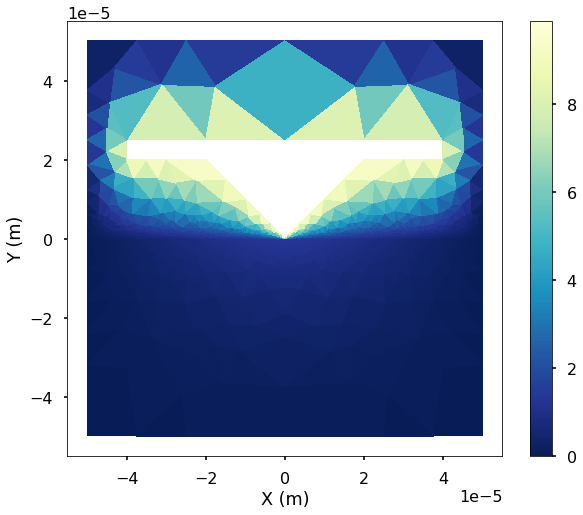

Computing fields and gradients in elements
Time elapsed  0.009032249450683594 sec



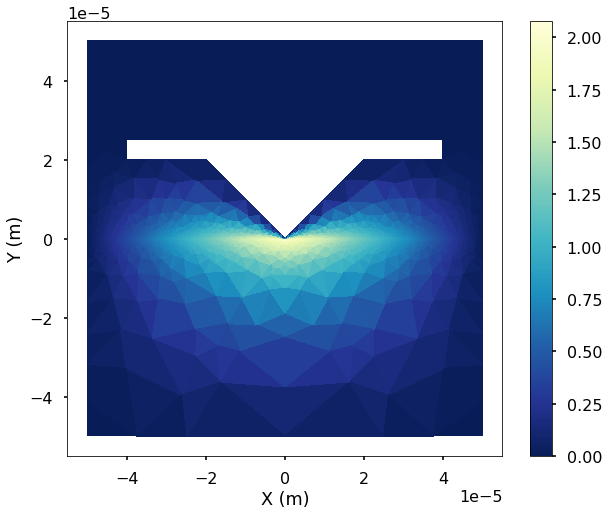

In [18]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

import numpy as np
from lib.mesh import Mesh
from lib.materials import PertPNP,Physics
from lib.assembly import PertFEM

#import mesh
mesh = Mesh.importer(
    prefix = 'mesh_ex06',
    axis_symmetry = 'Y',
    unscale_factor=1e-6,
    )

#define physical parameters
physics = Physics(
    c_ion = [0.0,0.0], #ion concentration at infinity [mol/m^3]
    z_ion = [-1.0,1.0], #ion valence or charge number [SI]
    mu_a = [5e-8,5e-8], #ion mobility in electrolyte [m^2/(Vs)]
    mu_s = 5e-9, #ion mobility in stern [m^2/(Vs)]
    rel_perm_a = 80.0, #relative permittivity of electrolyte [SI]
    rel_perm_i = 4.5, #relative permittivity of solid [SI]
    sigma_solid = -0.01, #surface charge density for solid [C] #sigma_intrinsic
    temperature = 293.0, #ambient temperature [K]
    e_0 = [0.0,0.0], #Ex/Ey at infinity
    f_0 = [[0.0,0.0,0.0]], #x/y/charge density at point sources
    s_0 = 10.0, #voltage on equipotential surface
    radius_a = 0.0, #radius of sphere particle
    is_solid_metal = False, #True if solid is metal otherwise false
    )

#build PDE using pre-defined physics
pde = PertPNP(physics)

#build FEM system
slab = PertFEM(mesh,pde)
slab.ftsolve(ratio=[1.0],freqtime=[3e4/(2*np.pi)],n_proc=1)

#display results
mesh.tripcolor(np.real(slab.fsol[0][0,:,-2]),cmap='YlGnBu_r')
mesh.tripcolor(np.imag(slab.fsol[0][0,:,-2]),cmap='YlGnBu_r')


## Coarse Grid Mesh

In [7]:
import numpy as np
import subprocess
from lib.mesh import Mesh,Probe,generate_grid
from lib.materials import Consts,PertPNP,Physics
from lib.assembly import PertFEM
from lib.utils import print_tstamp

def call_triangle(mesh_prefix,triangle_path):
    command = [triangle_path+' -pnAae '+mesh_prefix+'.poly']
    process = subprocess.Popen(command,shell=True)
    process.wait()

    return

kwargs = {'n':100,'m':100,'l_js':50, #number of grids: x,z+,z- below sample top
          'h0':1.0,'rho_max':10e6,'z_max':10e6, #resolution: h0, box_size (rho_max,z_max)
          'd_min':20,'d_max':110,'id_step':1, #tip-sample separation: min,max,istep (stepsize=istep*h0)
          'eps_r':5.9,'Hsam':10e6} #sample: eps_r, thickness_sample
x,y = generate_grid(**kwargs)

probe = Probe(
    #geometry of the background slab
    radius_air = 10e6, #radius of the air [nm]
    height_air = 10e6, #height of the air [nm]
    height_gap = 20.0, #gap between tip apex and sample surface [nm]
    height_water = 1.0, #thickness of thin water film
    height_solid = 10e6, #height of the solid

    #geometry of the cantilever probe
    radius_tip = 20, #radius of probe tip [nm]
    radius_cone = 15e3*np.tan(15/180*np.pi)+20, #radius of probe cone [nm]
    height_cone = 15e3+20, #height of probe cone [nm]
    radius_disk = 35e3, #radius of probe disk [nm]
    height_disk = 0.5e3, #height of probe disk [nm]

    #area constraints
    area_air = 1e12, #[nm]**2
    area_water = 1e12, #[nm]**2
    area_solid = 1e12, #[nm]**2

    #mesh construction parameters
    mesh_prefix = 'capsol/test',
    mesh_grid = [x,y],
    dist_factor = 1.0,
    build_mesh = False,
    )

physics = Physics(
    c_ion = [0.0,0.0], #ion concentration at infinity [mol/m^3]
    z_ion = [-1.0,1.0], #ion valence or charge number [SI]
    mu_a = [5e-8,5e-8], #ion mobility in electrolyte [m^2/(Vs)]
    mu_s = 5e-15, #ion mobility in stern [m^2/(Vs)]
    rel_perm_a = 80.0, #relative permittivity of electrolyte [SI]
    rel_perm_i = 4.5, #relative permittivity of solid [SI]
    sigma_solid = -0.01, #surface charge density for solid [C] #sigma_intrinsic
    temperature = 293.0, #ambient temperature [K]
    e_0 = [0.0,0.0], #Ex/Ey at infinity
    f_0 = [[0.0,0.0,0.0]], #x/y/charge density at point sources
    s_0 = 1.0, #voltage on equipotential surface
    radius_a = 0.0, #radius of sphere particle
    is_solid_metal = False, #True if solid is metal otherwise false
    )

call_triangle('capsol/test','triangle')
print('Done')

Writing capsol/test.poly

Opening capsol/test.poly.
Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  41
Recovering segments in Delaunay triangulation.
Segment milliseconds:  1
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  3
Adding Steiner points to enforce quality.
Quality milliseconds:  1

Writing capsol/test.1.node.
Writing capsol/test.1.ele.
Writing capsol/test.1.poly.
Writing capsol/test.1.edge.
Writing capsol/test.1.neigh.

Output milliseconds:  150
Total running milliseconds:  214

Statistics:

  Input vertices: 17271
  Input segments: 861
  Input holes: 1

  Mesh vertices: 16054
  Mesh triangles: 31500
  Mesh edges: 47553
  Mesh exterior boundary edges: 606
  Mesh interior boundary edges: 200
  Mesh subsegments (constrained edges): 806

Done


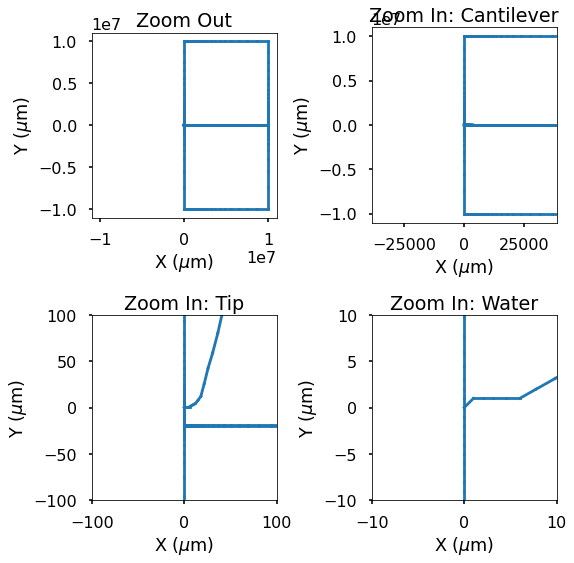

In [10]:
probe.visualize(cpt_flags=[],xunit='um',yunit='um')

Reading capsol/test.1.node
Reading capsol/test.1.ele
Reading capsol/test.1.edge
THE NUMBER OF NODES IS: 17285
THE NUMBER OF ELEMENTS IS: 31500
THE NUMBER OF EDGES IS: 47553
node_flags [ 0  1  2  3  4 11 12 14]
elem_flags [1 2 3]
edge_flags [ 0  1  2  3  4 11 12 14]



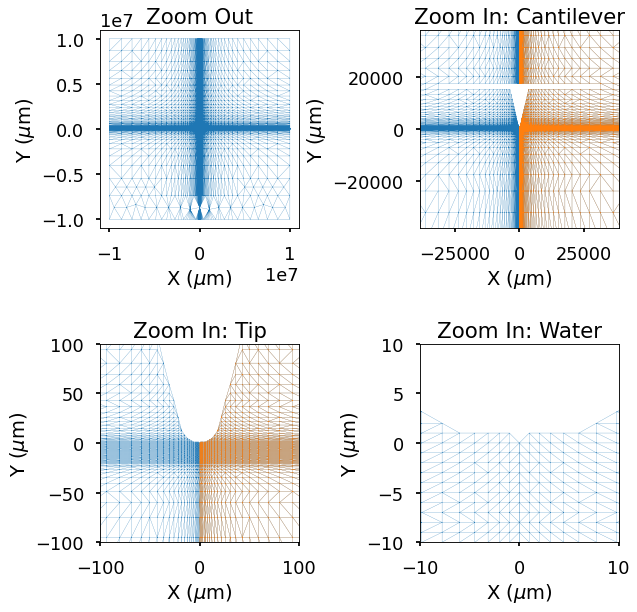

In [11]:
probe.triplot(xunit='um',yunit='um')

## Run simulation I

Reading capsol/test.1.node
Reading capsol/test.1.ele
Reading capsol/test.1.edge
THE NUMBER OF NODES IS: 17285
THE NUMBER OF ELEMENTS IS: 31500
THE NUMBER OF EDGES IS: 47553
node_flags [ 0  1  2  3  4 11 12 14]
elem_flags [1 2 3]
edge_flags [ 0  1  2  3  4 11 12 14]

Computing shape functions of triangular elements
This will take a minute
Time elapsed  1.1932668685913086 sec

Computing shape functions of line segments
This will take a minute
Time elapsed  0.05564117431640625 sec

Reading capsol/test.1.node
Reading capsol/test.1.ele
Reading capsol/test.1.edge

Computing shape functions of triangular elements
This will take a minute
Time elapsed  1.144404411315918 sec

Computing shape functions of line segments
This will take a minute
Time elapsed  0.054476261138916016 sec

Assembling the system of equations for triangular elements
This will take a while
Time elapsed  21.881466150283813 sec

Assembling the system of equations for line segments
Time elapsed  1.6531555652618408 sec

Incoorp

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.10s/it]


Time elapsed  4.1024415493011475 sec

Computing fields and gradients in elements
Time elapsed  0.005209207534790039 sec



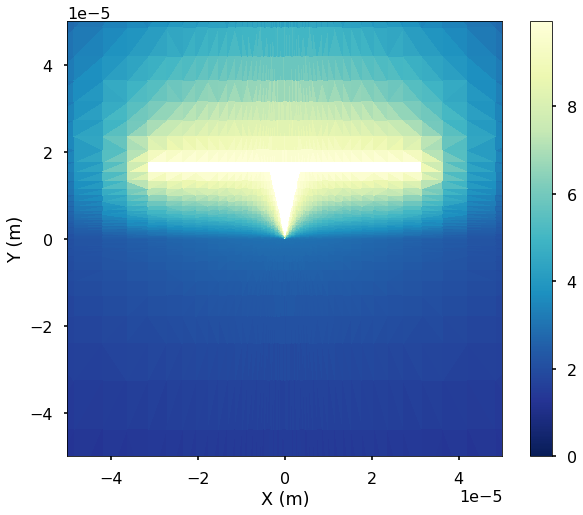

Computing fields and gradients in elements
Time elapsed  0.004971504211425781 sec



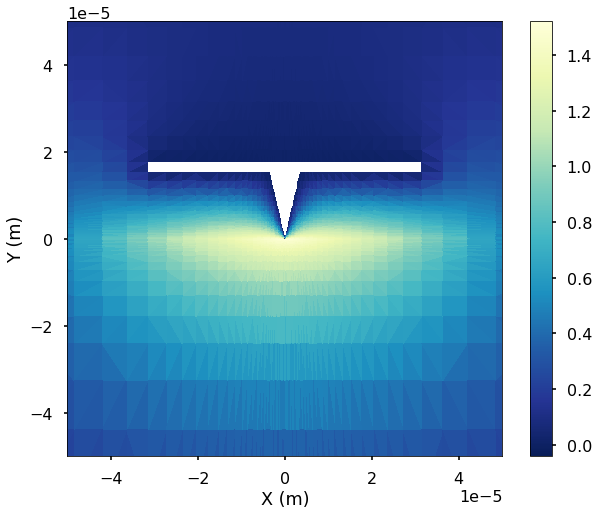

In [79]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

import numpy as np
from lib.mesh import Mesh
from lib.materials import PertPNP,Physics
from lib.assembly import PertFEM

#import mesh
mesh = Mesh.importer(
    prefix = 'capsol/test',
    axis_symmetry = 'Y',
    unscale_factor=1e-9,
    )

#define physical parameters
physics = Physics(
    c_ion = [0.0,0.0], #ion concentration at infinity [mol/m^3]
    z_ion = [-1.0,1.0], #ion valence or charge number [SI]
    mu_a = [5e-8,5e-8], #ion mobility in electrolyte [m^2/(Vs)]
    mu_s = 5e-9, #ion mobility in stern [m^2/(Vs)]
    rel_perm_a = 80.0, #relative permittivity of electrolyte [SI]
    rel_perm_i = 4.5, #relative permittivity of solid [SI]
    sigma_solid = -0.01, #surface charge density for solid [C] #sigma_intrinsic
    temperature = 293.0, #ambient temperature [K]
    e_0 = [0.0,0.0], #Ex/Ey at infinity
    f_0 = [[0.0,0.0,0.0]], #x/y/charge density at point sources
    s_0 = 10.0, #voltage on equipotential surface
    radius_a = 0.0, #radius of sphere particle
    is_solid_metal = False, #True if solid is metal otherwise false
    )

#build PDE using pre-defined physics
pde = PertPNP(physics)

#build FEM system
slab = PertFEM(mesh,pde)
slab.ftsolve(ratio=[1.0],freqtime=[3e4/(2*np.pi)],n_proc=1)

#display results
xlim = [-50e-6,50e-6]
ylim = [-50e-6,50e-6]
mesh.tripcolor(np.real(slab.fsol[0][0,:,-2]),cmap='YlGnBu_r',xlim=xlim,ylim=ylim)
mesh.tripcolor(np.imag(slab.fsol[0][0,:,-2]),cmap='YlGnBu_r',xlim=xlim,ylim=ylim)

In [80]:
tmp = PertFEM.load('capsol/test')

In [81]:
tmp.__dict__.keys()

dict_keys(['freq', 'ratio', 'ratio:1.00', 'mesh'])

In [82]:
tmp.fsol = [tmp.__dict__['ratio:1.00']]

Computing fields and gradients in elements
Time elapsed  0.0056116580963134766 sec



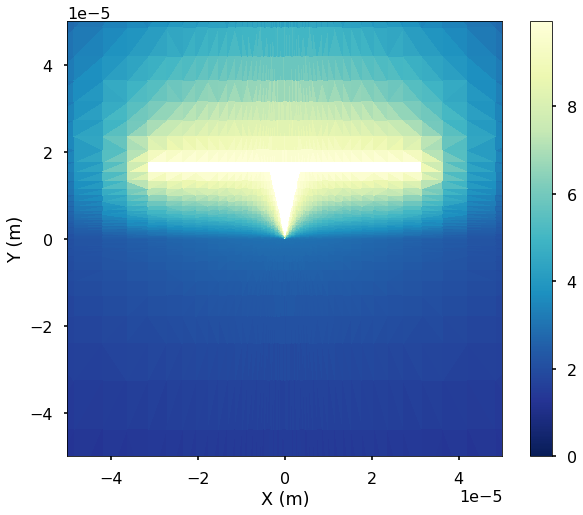

Computing fields and gradients in elements
Time elapsed  0.006449699401855469 sec



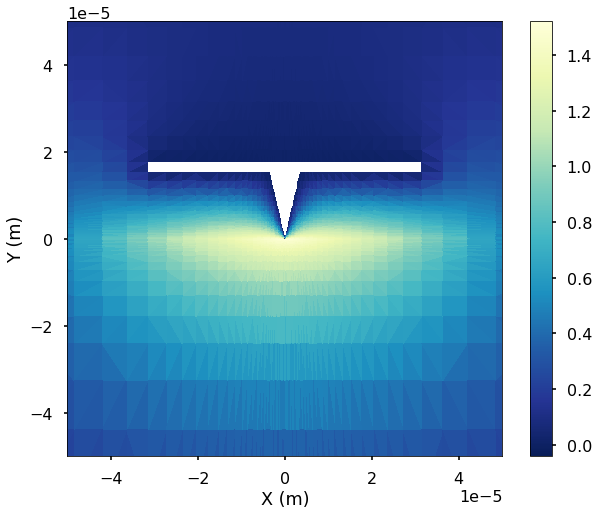

In [83]:
#display results
xlim = [-50e-6,50e-6]
ylim = [-50e-6,50e-6]
tmp.mesh.tripcolor(np.real(tmp.fsol[0][0,:,-2]),cmap='YlGnBu_r',xlim=xlim,ylim=ylim)
tmp.mesh.tripcolor(np.imag(tmp.fsol[0][0,:,-2]),cmap='YlGnBu_r',xlim=xlim,ylim=ylim)

## Run simulation II

Reading capsol/test.1.node
Reading capsol/test.1.ele
Reading capsol/test.1.edge
THE NUMBER OF NODES IS: 17285
THE NUMBER OF ELEMENTS IS: 31500
THE NUMBER OF EDGES IS: 47553
node_flags [ 0  1  2  3  4 11 12 14]
elem_flags [1 2 3]
edge_flags [ 0  1  2  3  4 11 12 14]

Computing shape functions of triangular elements
This will take a minute
Time elapsed  1.2465052604675293 sec

Computing shape functions of line segments
This will take a minute
Time elapsed  0.053603172302246094 sec

Reading capsol/test.1.node
Reading capsol/test.1.ele
Reading capsol/test.1.edge

Computing shape functions of triangular elements
This will take a minute
Time elapsed  1.1697123050689697 sec

Computing shape functions of line segments
This will take a minute
Time elapsed  0.05501747131347656 sec

Assembling the system of equations for triangular elements
This will take a while
Time elapsed  21.682419300079346 sec

Assembling the system of equations for line segments
Time elapsed  1.6246302127838135 sec

Incoor

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 175/175 [06:54<00:00,  2.37s/it]


Time elapsed  414.2741324901581 sec

Computing fields and gradients in elements
Time elapsed  0.0056917667388916016 sec



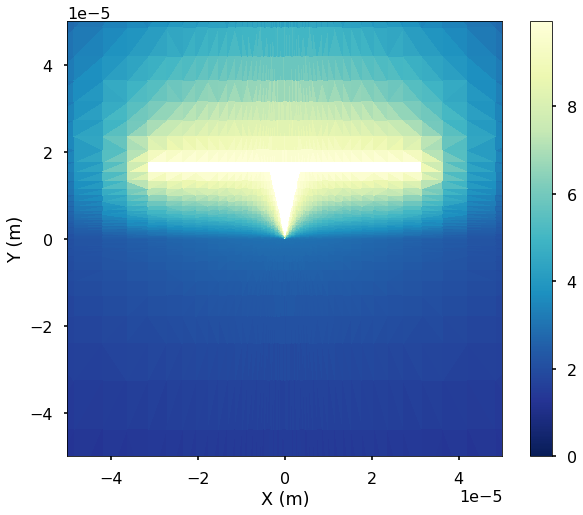

Computing fields and gradients in elements
Time elapsed  0.005190372467041016 sec



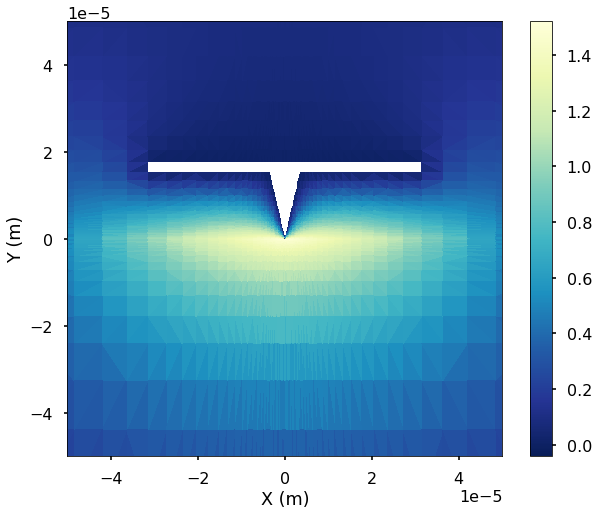

In [24]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

import numpy as np
from lib.mesh import Mesh
from lib.materials import PertPNP,Physics
from lib.assembly import PertFEM

#import mesh
mesh = Mesh.importer(
    prefix = 'capsol/test',
    axis_symmetry = 'Y',
    unscale_factor=1e-9,
    )

#define physical parameters
physics = Physics(
    c_ion = [0.0,0.0], #ion concentration at infinity [mol/m^3]
    z_ion = [-1.0,1.0], #ion valence or charge number [SI]
    mu_a = [5e-8,5e-8], #ion mobility in electrolyte [m^2/(Vs)]
    mu_s = 5e-15, #ion mobility in stern [m^2/(Vs)]
    rel_perm_a = 80.0, #relative permittivity of electrolyte [SI]
    rel_perm_i = 4.5, #relative permittivity of solid [SI]
    sigma_solid = -0.01, #surface charge density for solid [C] #sigma_intrinsic
    temperature = 293.0, #ambient temperature [K]
    e_0 = [0.0,0.0], #Ex/Ey at infinity
    f_0 = [[0.0,0.0,0.0]], #x/y/charge density at point sources
    s_0 = 1.0, #voltage on equipotential surface
    radius_a = 0.0, #radius of sphere particle
    is_solid_metal = False, #True if solid is metal otherwise false
    )

#build PDE using pre-defined physics
pde = PertPNP(physics)

#build FEM system
step_on = PertFEM(mesh,pde)
step_on.ftsolve(ratio=[1.0],freqtime=np.logspace(-6,2,301),signal=1,ft='dlf',
                ftarg={},n_proc=1)

#display results
xlim = [-50e-6,50e-6]
ylim = [-50e-6,50e-6]
mesh.tripcolor(np.real(slab.fsol[0][0,:,-2]),cmap='YlGnBu_r',xlim=xlim,ylim=ylim)
mesh.tripcolor(np.imag(slab.fsol[0][0,:,-2]),cmap='YlGnBu_r',xlim=xlim,ylim=ylim)

Computing fields and gradients in elements
Time elapsed  0.006211996078491211 sec



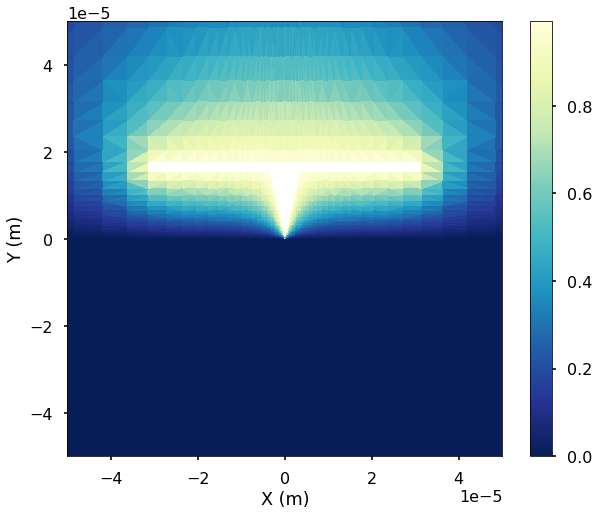

Computing fields and gradients in elements
Time elapsed  0.005822420120239258 sec



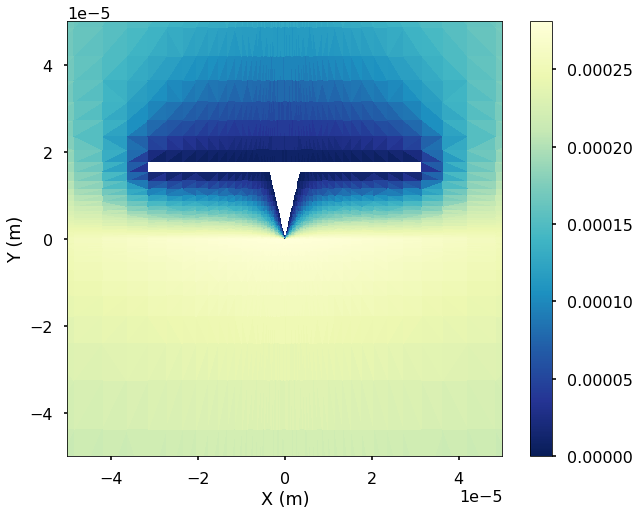

In [88]:
#display results
xlim = [-50e-6,50e-6]
ylim = [-50e-6,50e-6]
step_on.mesh.tripcolor(np.real(step_on.fsol[0][0,:,-2]),cmap='YlGnBu_r',xlim=xlim,ylim=ylim)
step_on.mesh.tripcolor(np.imag(step_on.fsol[0][0,:,-2]),cmap='YlGnBu_r',xlim=xlim,ylim=ylim)

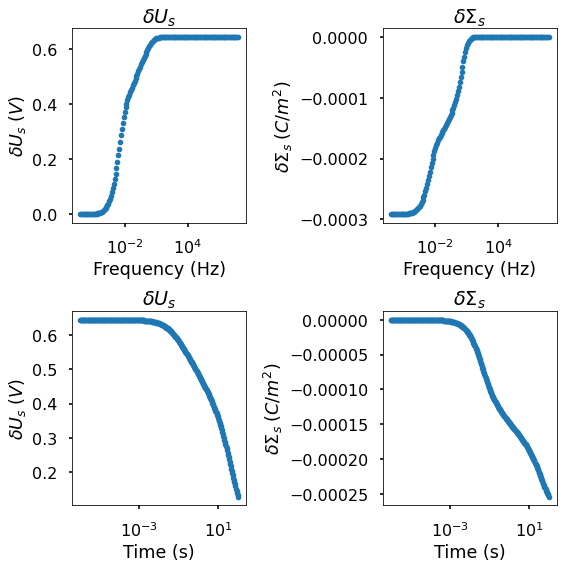

In [25]:
step_on.plot(x=0,y=0)

## Transform results

   time        [s] :  1E-06 - 1E+06 : 301  [min-max; #]
   Fourier         :  FFTLog
     > pts_per_dec :  10
     > add_dec     :  [-6.  6.]
     > q           :  -0.6

freq_1 min - max: 5.34E-07 - 6.93E+08
freq_2 min - max: 1.79E-13 - 1.42E+11


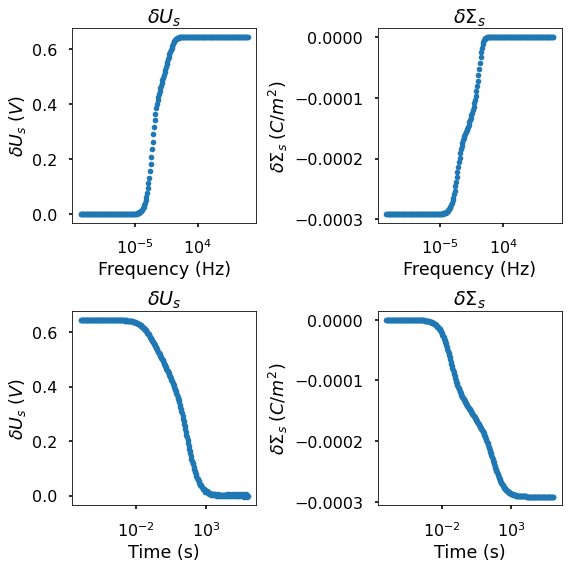

In [48]:
from scipy.interpolate import InterpolatedUnivariateSpline as iuSpline

def test(fem,x,y,i=0):
    time = np.logspace(-6,6,301)
    signal = 1
    ft = 'fftlog'
    ftarg = {'q':-0.6,'add_dec':[-6,6]}
    #ft = 'fft'
    #ftarg={'dfreq': .0005, 'nfreq': 2**8, 'pts_per_dec': 10,'add_dec':[-2,5]}
    time,freq,ft,ftarg = step_on.argft(time,signal,ft,ftarg)
    print('freq_1 min - max: {0:.2E} - {1:.2E}'.format(min(fem.freq),max(fem.freq)))
    print('freq_2 min - max: {0:.2E} - {1:.2E}'.format(min(freq),max(freq)))
    fsol_in = fem.fsol[i][:,fem.mesh.is_on_stern,:]
    fsol_out = np.zeros((len(freq),len(fem.mesh.nodes),fsol_in.shape[2]),
                        dtype=complex)
    fsol_1 = np.zeros((len(freq),fsol_in.shape[1],fsol_in.shape[2]),dtype=float)
    fsol_2 = np.zeros((len(freq),fsol_in.shape[1],fsol_in.shape[2]),dtype=float)
    #print(fsol_in.shape)
    #print(fsol_out.shape)
    #print(fsol_1.shape)
    #print(fsol_2.shape)
    for j in range(fsol_in.shape[1]):
        for k in range(fsol_in.shape[2]):
            func_1 = iuSpline(fem.freq,np.real(fsol_in[:,j,k]))
            fsol_1[:,j,k] = func_1(freq)
            func_2 = iuSpline(fem.freq,np.imag(fsol_in[:,j,k]))
            fsol_2[:,j,k] = func_2(freq)
            mask = freq<min(fem.freq)
            fsol_1[mask,j,k] = np.real(fsol_in[0,j,k])
            fsol_2[mask,j,k] = np.imag(fsol_in[0,j,k])
            mask = freq>max(fem.freq)
            fsol_1[mask,j,k] = np.real(fsol_in[-1,j,k])
            fsol_2[mask,j,k] = np.imag(fsol_in[-1,j,k])
            #fsol_1[:,j,k] = np.real(fsol_in[:,j,k])
            #fsol_2[:,j,k] = np.imag(fsol_in[:,j,k])
    fsol_out[:,fem.mesh.is_on_stern,:] = fsol_1+1j*fsol_2
    fsol = fsol_out[:,fem.mesh.is_on_stern,:]
    tsol = fem.transform([fsol_out],freq,time,signal,ft,ftarg)[0]

    if True:
        nodes = fem.mesh.nodes[fem.mesh.is_on_stern,:]
        n_ind = np.argmin((nodes[:,0]-x)**2+(nodes[:,1]-y)**2)

        fig,ax = plt.subplots(2,2,figsize=(8,8))
        axes = ax.flatten()

        axes[0].plot(freq,np.real(fsol[:,n_ind,-2]),'.')
        axes[1].plot(freq,np.real(fsol[:,n_ind,-1]),'.')
        axes[2].plot(time,np.real(tsol[:,n_ind,-2]),'.')
        axes[3].plot(time,np.real(tsol[:,n_ind,-1]),'.')

        axes[0].set_xscale('log')
        axes[1].set_xscale('log')
        axes[2].set_xscale('log')
        axes[3].set_xscale('log')

        axes[0].set_xlabel('Frequency (Hz)')
        axes[1].set_xlabel('Frequency (Hz)')
        axes[2].set_xlabel('Time (s)')
        axes[3].set_xlabel('Time (s)')
        
        axes[0].set_ylabel('$\delta U_s \;(V)$')
        axes[1].set_ylabel('$\delta \Sigma_s \;(C/m^2)$')
        axes[2].set_ylabel('$\delta U_s \;(V)$')
        axes[3].set_ylabel('$\delta \Sigma_s \;(C/m^2)$')
        
        #axes[0].set_ylabel('(V)')
        #axes[1].set_ylabel('(C/m^2)')
        #axes[2].set_ylabel('(V)')
        #axes[3].set_ylabel('(C/m^2)')
        
        #axes[0].set_title('(X,Y) = ({0:.2e},{1:.2e})'.format(x,y))
        #axes[1].set_title('(X,Y) = ({0:.2e},{1:.2e})'.format(x,y))
        
        axes[0].set_title('$\delta U_s$')
        axes[1].set_title('$\delta \Sigma_s$')
        axes[2].set_title('$\delta U_s$')
        axes[3].set_title('$\delta \Sigma_s$')

        plt.tight_layout()
        plt.show()
    return

if __name__=='__main__':
    test(step_on,x=0,y=0)

   time        [s] :  1E-06 - 1E+06 : 301  [min-max; #]
   Fourier         :  FFTLog
     > pts_per_dec :  10
     > add_dec     :  [-6.  6.]
     > q           :  -0.6

freq_1 min - max: 5.34E-07 - 6.93E+08
freq_2 min - max: 1.79E-13 - 1.42E+11


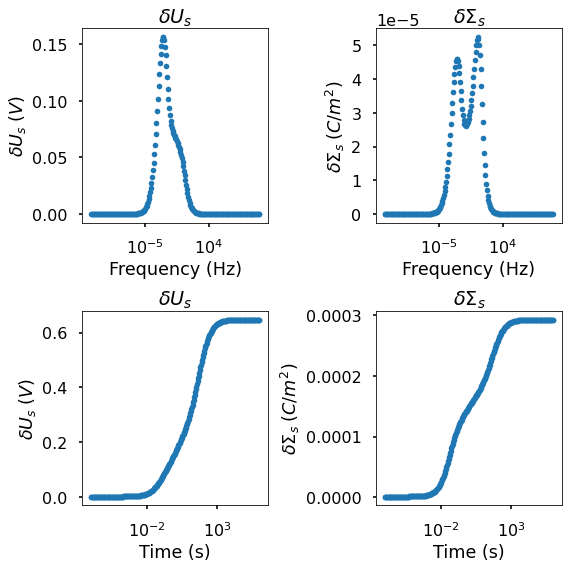

In [49]:
from scipy.interpolate import InterpolatedUnivariateSpline as iuSpline

def test(fem,x,y,i=0):
    time = np.logspace(-6,6,301)
    signal = -1
    ft = 'fftlog'
    ftarg = {'q':-0.6,'add_dec':[-6,6]}
    #ft = 'fft'
    #ftarg={'dfreq': .0005, 'nfreq': 2**8, 'pts_per_dec': 10,'add_dec':[-2,5]}
    time,freq,ft,ftarg = step_on.argft(time,signal,ft,ftarg)
    print('freq_1 min - max: {0:.2E} - {1:.2E}'.format(min(fem.freq),max(fem.freq)))
    print('freq_2 min - max: {0:.2E} - {1:.2E}'.format(min(freq),max(freq)))
    fsol_in = fem.fsol[i][:,fem.mesh.is_on_stern,:]
    fsol_out = np.zeros((len(freq),len(fem.mesh.nodes),fsol_in.shape[2]),
                        dtype=complex)
    fsol_1 = np.zeros((len(freq),fsol_in.shape[1],fsol_in.shape[2]),dtype=float)
    fsol_2 = np.zeros((len(freq),fsol_in.shape[1],fsol_in.shape[2]),dtype=float)
    #print(fsol_in.shape)
    #print(fsol_out.shape)
    #print(fsol_1.shape)
    #print(fsol_2.shape)
    for j in range(fsol_in.shape[1]):
        for k in range(fsol_in.shape[2]):
            func_1 = iuSpline(fem.freq,np.real(fsol_in[:,j,k]))
            fsol_1[:,j,k] = func_1(freq)
            func_2 = iuSpline(fem.freq,np.imag(fsol_in[:,j,k]))
            fsol_2[:,j,k] = func_2(freq)
            mask = freq<min(fem.freq)
            fsol_1[mask,j,k] = np.real(fsol_in[0,j,k])
            fsol_2[mask,j,k] = np.imag(fsol_in[0,j,k])
            mask = freq>max(fem.freq)
            fsol_1[mask,j,k] = np.real(fsol_in[-1,j,k])
            fsol_2[mask,j,k] = np.imag(fsol_in[-1,j,k])
            #fsol_1[:,j,k] = np.real(fsol_in[:,j,k])
            #fsol_2[:,j,k] = np.imag(fsol_in[:,j,k])
    fsol_out[:,fem.mesh.is_on_stern,:] = fsol_1+1j*fsol_2
    fsol = fsol_out[:,fem.mesh.is_on_stern,:]
    tsol = fem.transform([fsol_out],freq,time,signal,ft,ftarg)[0]

    if True:
        nodes = fem.mesh.nodes[fem.mesh.is_on_stern,:]
        n_ind = np.argmin((nodes[:,0]-x)**2+(nodes[:,1]-y)**2)

        fig,ax = plt.subplots(2,2,figsize=(8,8))
        axes = ax.flatten()

        axes[0].plot(freq,np.imag(fsol[:,n_ind,-2]),'.')
        axes[1].plot(freq,np.imag(fsol[:,n_ind,-1]),'.')
        axes[2].plot(time,np.real(tsol[:,n_ind,-2]),'.')
        axes[3].plot(time,np.real(tsol[:,n_ind,-1]),'.')

        axes[0].set_xscale('log')
        axes[1].set_xscale('log')
        axes[2].set_xscale('log')
        axes[3].set_xscale('log')

        axes[0].set_xlabel('Frequency (Hz)')
        axes[1].set_xlabel('Frequency (Hz)')
        axes[2].set_xlabel('Time (s)')
        axes[3].set_xlabel('Time (s)')
        
        axes[0].set_ylabel('$\delta U_s \;(V)$')
        axes[1].set_ylabel('$\delta \Sigma_s \;(C/m^2)$')
        axes[2].set_ylabel('$\delta U_s \;(V)$')
        axes[3].set_ylabel('$\delta \Sigma_s \;(C/m^2)$')
        
        #axes[0].set_ylabel('(V)')
        #axes[1].set_ylabel('(C/m^2)')
        #axes[2].set_ylabel('(V)')
        #axes[3].set_ylabel('(C/m^2)')
        
        #axes[0].set_title('(X,Y) = ({0:.2e},{1:.2e})'.format(x,y))
        #axes[1].set_title('(X,Y) = ({0:.2e},{1:.2e})'.format(x,y))
        
        axes[0].set_title('$\delta U_s$')
        axes[1].set_title('$\delta \Sigma_s$')
        axes[2].set_title('$\delta U_s$')
        axes[3].set_title('$\delta \Sigma_s$')

        plt.tight_layout()
        plt.show()
    return

if __name__=='__main__':
    test(step_on,x=0,y=0)

In [53]:
step_on.fsol[0].dtype

dtype('complex128')

In [56]:
pde.shape

(4, 4)

In [57]:
mesh.prefix

'capsol/test'

# Force Gradient

In [1]:
%load_ext autoreload
%autoreload 2

## Benchmark Gradient

In [49]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

import numpy as np
import os

from lib.mesh import Mesh,Probe,generate_grid
from lib.materials import Consts,PDE
from lib.assembly import FEM
from lib.utils import print_tstamp

inparg = {'n':500,'m':500,'l_js':350, #number of grids: x,z+,z- below sample top
          'h0':1,'rho_max':10e6,'z_max':10e6, #resolution: h0, box_size (rho_max,z_max)
          'd_min':2,'d_max':20,'id_step':1, #tip-sample separation: min,max,istep (stepsize=istep*h0)
          'eps_r':5.9,'Hsam':10e6} #sample: eps_r, thickness_sample

height_gap = np.arange(2,21,1)
force = np.zeros(len(height_gap))
for i in range(len(height_gap)):
# for i in range(1):
    #update grid discretization
    inparg['d_min'] = height_gap[i]
    x,y = generate_grid(**inparg)

    #mesh_prefix = 'test/stat_s{:02.1f}nm'.format(height_gap[i])
    mesh_prefix = 'capsol/test_4/test4_s{:02.1f}nm'.format(height_gap[i])
    print(mesh_prefix)
    stat = FEM.load(mesh_prefix)
    stat.mesh.grid_x = x*stat.mesh.unscale_factor
    stat.mesh.grid_y = y*stat.mesh.unscale_factor
    f_out = stat.mesh.force2d(stat.sol)
    os.rename('force.out',mesh_prefix+'.fz')
    force[i] = np.sum(f_out[:,2])
    print('i',i,'force',force[i])

capsol/test_4/test4_s2.0nm
i 0 force 3.6412110278357632
capsol/test_4/test4_s3.0nm
i 1 force 3.538457274015151
capsol/test_4/test4_s4.0nm
i 2 force 3.470923737795367
capsol/test_4/test4_s5.0nm
i 3 force 3.4217523781452854
capsol/test_4/test4_s6.0nm
i 4 force 3.3841770397159836
capsol/test_4/test4_s7.0nm
i 5 force 3.355225823720463
capsol/test_4/test4_s8.0nm
i 6 force 3.33134509449677
capsol/test_4/test4_s9.0nm
i 7 force 3.311653614097261
capsol/test_4/test4_s10.0nm
i 8 force 3.294977050542043
capsol/test_4/test4_s11.0nm
i 9 force 3.2801737548288132
capsol/test_4/test4_s12.0nm
i 10 force 3.268285453347019
capsol/test_4/test4_s13.0nm
i 11 force 3.257409116021369
capsol/test_4/test4_s14.0nm
i 12 force 3.247699337626302
capsol/test_4/test4_s15.0nm
i 13 force 3.2388405265554754
capsol/test_4/test4_s16.0nm
i 14 force 3.2307233684816556
capsol/test_4/test4_s17.0nm
i 15 force 3.2231717411263454
capsol/test_4/test4_s18.0nm
i 16 force 3.2168409755433616
capsol/test_4/test4_s19.0nm
i 17 force 3.2

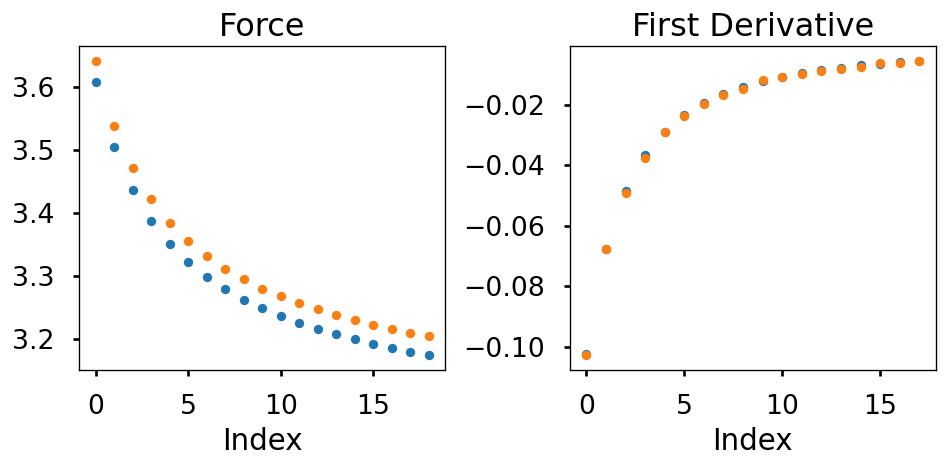

In [52]:
# height_gap = np.arange(2,20+1,1) #[nm]
dir_1 = 'capsol/grid_500_s10_h1.0/'
dir_2 = 'capsol/grid_500_s10_h0.5/'

force_1 = [0.0]*len(height_gap)
force_2 = [0.0]*len(height_gap)
for i in range(len(height_gap)):
    s = height_gap[i]/20
    file_name = 'Fz.dat{0:1.4f}'.format(s)
    data = np.genfromtxt(dir_1+file_name,skip_header=1,usecols=(0,3,1))
    force_1[i] = data[-1,-1]
    
    data = np.genfromtxt(dir_2+file_name,skip_header=1,usecols=(0,3,1))
    force_2[i] = data[-1,-1]

fig,ax = plt.subplots(1,2,figsize=(8,4),dpi=120)
axes = ax.ravel()
# ax.plot(offset_tip,force,'.')
# ax.plot(offset_tip,force2,'.')
# ax.plot(offset_tip,force3,'.')
axes[0].plot(np.diff(force_1,n=0),'.')
# axes[0].plot(np.diff(force_2,n=0),'.')
axes[0].plot(np.diff(force,n=0),'.')
axes[0].set_xlabel('Index')
axes[0].set_title('Force')

axes[1].plot(np.diff(force_1,n=1),'.')
# axes[1].plot(np.diff(force_2,n=1),'.')
axes[1].plot(np.diff(force,n=1),'.')
axes[1].set_xlabel('Index')
axes[1].set_title('First Derivative')

plt.tight_layout()
plt.show()

## Test Gradient

In [56]:
import numpy as np
import subprocess
from lib.mesh import Mesh,Probe,generate_grid
from lib.materials import Consts,PDE
from lib.assembly import FEM
from lib.utils import print_tstamp

def call_triangle(mesh_prefix,triangle_path):
    command = [triangle_path+' -pnAae '+mesh_prefix+'.poly']
    process = subprocess.Popen(command,shell=True)
    process.wait()

    return

#===============================================================================
#CapSol Grid
inparg = {'n':500,'m':500,'l_js':350, #number of grids: x,z+,z- below sample top
          'h0':1,'rho_max':10e6,'z_max':10e6, #resolution: h0, box_size (rho_max,z_max)
          'd_min':20,'d_max':110,'id_step':1, #tip-sample separation: min,max,istep (stepsize=istep*h0)
          'eps_r':5.9,'Hsam':10e6} #sample: eps_r, thickness_sample
x,y = generate_grid(**inparg)

#Probe Geometry
probe = Probe(
    #geometry of the background slab
    radius_air = 10e6, #radius of the air
    height_air = 10e6, #height of the air
    height_gap = 20.0, #gap between tip apex and sample surface [nm]
    height_water = 1.0, #thickness of thin water film
    height_solid = 10e6, #height of the solid

    #geometry of the cantilever probe
    radius_tip = 20, #radius of probe tip [nm]
    radius_cone = 15e3*np.tan(15/180*np.pi)+20, #radius of probe cone [nm]
    height_cone = 15e3+20, #height of probe cone [nm]
    radius_disk = 35e3, #radius of probe disk [nm]
    height_disk = 0.5e3, #height of probe disk [nm]

    #area constraints
    area_air = 1e12, #[nm]**2
    area_water = 1e12, #[nm]**2
    area_solid = 1e12, #[nm]**2

    #mesh construction parameters
    mesh_prefix = 'test',
    mesh_grid = [x,y],
    dist_factor = 1.0,
    build_mesh = False,
    )

#define PDE
pde = PDE(
    c_x = {'is_in_air':[[1.0*Consts.p]],
           'is_in_water':[[1.0*Consts.p]],
           'is_in_solid':[[5.9*Consts.p]]},
    c_y = {'is_in_air':[[1.0*Consts.p]],
           'is_in_water':[[1.0*Consts.p]],
           'is_in_solid':[[5.9*Consts.p]]},
    s_n = {'is_on_inner_bound':[1.0],
           'is_on_top_bound':[0.0],
           'is_on_bottom_bound':[0.0],
           'is_on_right_bound':[0.0],
           'is_on_outside_domain':[0.0]},
    )

#===============================================================================
height_gap = np.arange(2,20+1,1)

for i in range(0,len(height_gap)):
    mesh_prefix = 'test/stat_s{:02.1f}nm'.format(height_gap[i])
    print(mesh_prefix)

    #update grid discretization
    inparg['d_min'] = height_gap[i]
    x,y = generate_grid(**inparg)

    #update probe geometry and control points
    probe.height_gap = height_gap[i]
    probe.mesh_prefix = mesh_prefix
    probe.mesh_grid = [x,y]
    probe.build_mesh = False
    probe.build()
    call_triangle(mesh_prefix,'triangle')

#     #update PDE boundary condition
#     f_name = 'fort.{0:.0f}00'.format(1e3+height_gap[i])
#     d_in = np.genfromtxt('capsol/grid_500_4/'+f_name)
#     r = np.reshape(d_in[:,0],(len(x),-1))[:,0]
#     z = np.reshape(d_in[:,1],(len(x),-1))[0,:]

#     #boundary condition at top
#     z_ind = np.argmin(abs(z-max(probe.cpts[:,1])))
#     pot_top = d_in[z_ind::len(z),2]
#     print('Top Bound:',np.unique(d_in[z_ind::len(z),1]),max(probe.cpts[:,1]))

#     #boundary condition at bottom
#     z_ind = np.argmin(abs(z-min(probe.cpts[:,1])))
#     pot_bot = d_in[z_ind::len(z),2]
#     print('Bottom Bound:',np.unique(d_in[z_ind::len(z),1]),min(probe.cpts[:,1]))

#     #boundary condition at right side
#     r_ind = np.argmin(abs(r-max(probe.cpts[:,0])))
#     pot_rs = d_in[r_ind*len(z):r_ind*len(z)+len(z),2]
#     print('Right Bound:',np.unique(d_in[r_ind*len(z):r_ind*len(z)+len(z),0]),
#           max(probe.cpts[:,0]))

#     def build_s_top(x,y,*args):
#         return interp1d(r,pot_top)(x)

#     def build_s_bot(x,y,*args):
#         return interp1d(r,pot_bot)(x)

#     def build_s_rs(x,y,*args):
#         return interp1d(z,pot_rs)(y)

#     pde.s_n['is_on_top_bound'] = [build_s_top]
#     pde.s_n['is_on_bottom_bound'] = [build_s_bot]
#     pde.s_n['is_on_right_bound'] = [build_s_rs]

    #import mesh
    mesh = Mesh(
        prefix = mesh_prefix,
        axis_symmetry = 'Y',
        unscale_factor = 1e-9,
        )

    #build FEM system
    stat = FEM(mesh,pde)
    stat.solve()
    stat.save(mesh_prefix)
    print_tstamp()


Writing test.poly

test/stat_s2.0nm
Writing test/stat_s2.0nm.poly

Opening test/stat_s2.0nm.poly.
Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  771
Recovering segments in Delaunay triangulation.
Segment milliseconds:  11
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  71
Adding Steiner points to enforce quality.
Quality milliseconds:  23

Writing test/stat_s2.0nm.1.node.
Writing test/stat_s2.0nm.1.ele.
Writing test/stat_s2.0nm.1.poly.
Writing test/stat_s2.0nm.1.edge.
Writing test/stat_s2.0nm.1.neigh.

Output milliseconds:  2138
Total running milliseconds:  3242

Statistics:

  Input vertices: 427353
  Input segments: 4251
  Input holes: 1

  Mesh vertices: 406995
  Mesh triangles: 810978
  Mesh edges: 1217972
  Mesh exterior boundary edges: 3010
  Mesh interior boundary edges: 1000
  Mesh subsegments (constrained edges): 4010

Reading test/stat_s2.0nm.1.node
Reading test/stat_s2.0nm.1.ele
R

In [57]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

import numpy as np
import os

from lib.mesh import Mesh,Probe,generate_grid
from lib.materials import Consts,PDE
from lib.assembly import FEM
from lib.utils import print_tstamp

inparg = {'n':500,'m':500,'l_js':350, #number of grids: x,z+,z- below sample top
          'h0':1,'rho_max':10e6,'z_max':10e6, #resolution: h0, box_size (rho_max,z_max)
          'd_min':2,'d_max':20,'id_step':1, #tip-sample separation: min,max,istep (stepsize=istep*h0)
          'eps_r':5.9,'Hsam':10e6} #sample: eps_r, thickness_sample

height_gap = np.arange(2,21,1)
# height_gap = height_gap[:9]
force = np.zeros(len(height_gap))
for i in range(len(height_gap)):
# for i in range(4):
    #update grid discretization
    inparg['d_min'] = height_gap[i]
    x,y = generate_grid(**inparg)

    mesh_prefix = 'test/stat_s{:02.1f}nm'.format(height_gap[i])
    #mesh_prefix = 'capsol/test_4/test4_s{:02.1f}nm'.format(height_gap[i])
    print(mesh_prefix)
    stat = FEM.load(mesh_prefix)
    stat.mesh.grid_x = x*stat.mesh.unscale_factor
    stat.mesh.grid_y = y*stat.mesh.unscale_factor
    f_out = stat.mesh.force2d(stat.sol)
    os.rename('force.out',mesh_prefix+'.fz')
    force[i] = np.sum(f_out[:,2])
    print('i',i,'force',force[i])

test/stat_s2.0nm
i 0 force 3.6412110278031458
test/stat_s3.0nm
i 1 force 3.5384572739178326
test/stat_s4.0nm
i 2 force 3.4709237377728464
test/stat_s5.0nm
i 3 force 3.421752378128554
test/stat_s6.0nm
i 4 force 3.3841770397185575
test/stat_s7.0nm
i 5 force 3.3552258236788433
test/stat_s8.0nm
i 6 force 3.331345094476698
test/stat_s9.0nm
i 7 force 3.3116536140754667
test/stat_s10.0nm
i 8 force 3.2949770505249503
test/stat_s11.0nm
i 9 force 3.28017375482323
test/stat_s12.0nm
i 10 force 3.268285453266606
test/stat_s13.0nm
i 11 force 3.257409115995077
test/stat_s14.0nm
i 12 force 3.2476993376249177
test/stat_s15.0nm
i 13 force 3.2388405265522096
test/stat_s16.0nm
i 14 force 3.2307233684699614
test/stat_s17.0nm
i 15 force 3.2231717410518885
test/stat_s18.0nm
i 16 force 3.2168409754978637
test/stat_s19.0nm
i 17 force 3.210485686435082
test/stat_s20.0nm
i 18 force 3.2048212228200397


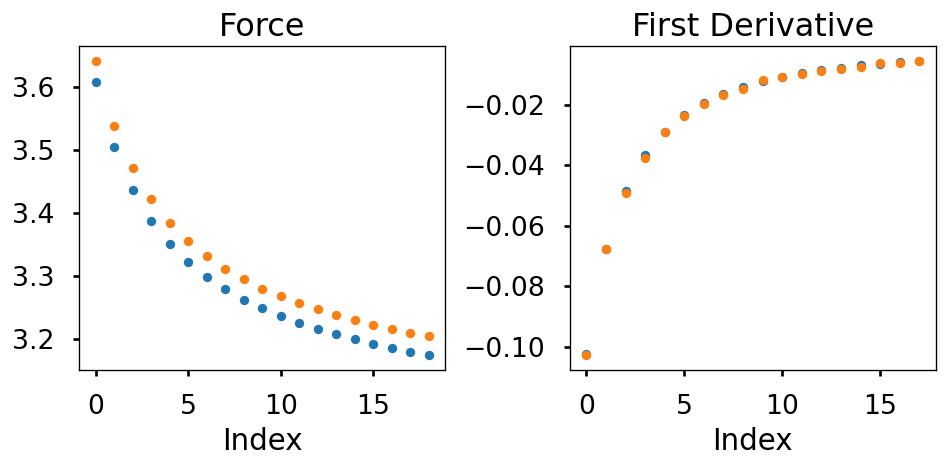

In [58]:
# height_gap = np.arange(2,20+1,1) #[nm]
dir_1 = 'capsol/grid_500_s10_h1.0/'
dir_2 = 'capsol/grid_500_s10_h0.5/'

force_1 = [0.0]*len(height_gap)
force_2 = [0.0]*len(height_gap)
for i in range(len(height_gap)):
    s = height_gap[i]/20
    file_name = 'Fz.dat{0:1.4f}'.format(s)
    data = np.genfromtxt(dir_1+file_name,skip_header=1,usecols=(0,3,1))
    force_1[i] = data[-1,-1]
    
    data = np.genfromtxt(dir_2+file_name,skip_header=1,usecols=(0,3,1))
    force_2[i] = data[-1,-1]

fig,ax = plt.subplots(1,2,figsize=(8,4),dpi=120)
axes = ax.ravel()
# ax.plot(offset_tip,force,'.')
# ax.plot(offset_tip,force2,'.')
# ax.plot(offset_tip,force3,'.')
axes[0].plot(np.diff(force_1,n=0),'.')
# axes[0].plot(np.diff(force_2,n=0),'.')
axes[0].plot(np.diff(force,n=0),'.')
axes[0].set_xlabel('Index')
axes[0].set_title('Force')

axes[1].plot(np.diff(force_1,n=1),'.')
# axes[1].plot(np.diff(force_2,n=1),'.')
axes[1].plot(np.diff(force,n=1),'.')
axes[1].set_xlabel('Index')
axes[1].set_title('First Derivative')

plt.tight_layout()
plt.show()

In [81]:
mask = stat.mesh.nodes==-2.0e-8
print(np.sum(mask),np.sum(stat.mesh.is_on_stern))

501 501


In [76]:
print(np.unique(mesh.nodes[:,1]))

[-1.00000200e-02 -9.63950238e-03 -9.29198202e-03 -8.95699035e-03
 -8.63407568e-03 -8.32280263e-03 -8.02275149e-03 -7.73351770e-03
 -7.45471126e-03 -7.18595627e-03 -6.92689033e-03 -6.67716416e-03
 -6.43644103e-03 -6.20439638e-03 -5.98071732e-03 -5.76510226e-03
 -5.55726048e-03 -5.35691175e-03 -5.16378592e-03 -4.97762261e-03
 -4.79817078e-03 -4.62518850e-03 -4.45844252e-03 -4.29770801e-03
 -4.14276824e-03 -3.99341431e-03 -3.84944484e-03 -3.71066571e-03
 -3.57688980e-03 -3.44793673e-03 -3.32363264e-03 -3.20380992e-03
 -3.08830700e-03 -2.97696816e-03 -2.86964327e-03 -2.76618762e-03
 -2.66646172e-03 -2.57033110e-03 -2.47766615e-03 -2.38834193e-03
 -2.30223800e-03 -2.21923825e-03 -2.13923079e-03 -2.06210773e-03
 -1.98776508e-03 -1.91610261e-03 -1.84702369e-03 -1.78043518e-03
 -1.71624730e-03 -1.65437350e-03 -1.59473035e-03 -1.53723744e-03
 -1.48181724e-03 -1.42839503e-03 -1.37689878e-03 -1.32725906e-03
 -1.27940893e-03 -1.23328388e-03 -1.18882172e-03 -1.14596249e-03
 -1.10464841e-03 -1.06482

## Force vs Time

In [39]:
from lib.assembly import PertFEM
pert1 = PertFEM.load('capsol/test_pert/pert_1_s20.0nm')
pert2 = PertFEM.load('capsol/test_pert/pert_2_s20.0nm')

fsol = pert1.__dict__['ratio:1.00']
fsol[66:] = pert2.__dict__['ratio:1.00']

pert = pert1
pert.fsol = [fsol]

In [41]:
fsol.ndim

3

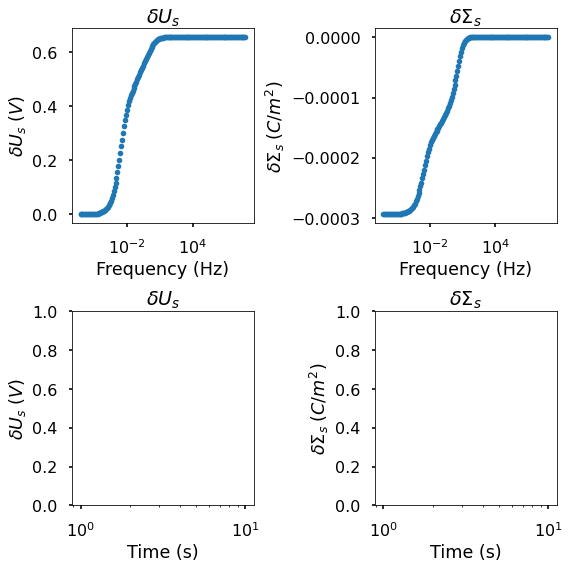

In [40]:
pert.plot2(x=0,y=0)

   time        [s] :  1E-06 - 1E+06 : 301  [min-max; #]
   Fourier         :  FFTLog
     > pts_per_dec :  10
     > add_dec     :  [-6.  6.]
     > q           :  -0.6

freq_1 min - max: 5.34E-07 - 6.93E+08
freq_2 min - max: 1.79E-13 - 1.42E+11


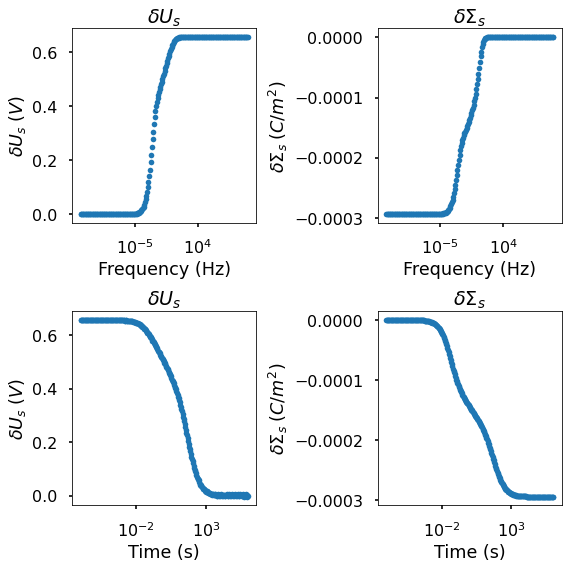

In [34]:
from scipy.interpolate import InterpolatedUnivariateSpline as iuSpline

def test(fem,x,y,i=0):
    time = np.logspace(-6,6,301)
    signal = 1
    ft = 'fftlog'
    ftarg = {'q':-0.6,'add_dec':[-6,6]}
    #ft = 'fft'
    #ftarg={'dfreq': .0005, 'nfreq': 2**8, 'pts_per_dec': 10,'add_dec':[-2,5]}
    time,freq,ft,ftarg = fem.argft(time,signal,ft,ftarg)
    print('freq_1 min - max: {0:.2E} - {1:.2E}'.format(min(fem.freq),max(fem.freq)))
    print('freq_2 min - max: {0:.2E} - {1:.2E}'.format(min(freq),max(freq)))
    fsol_in = fem.fsol[i][:,fem.mesh.is_on_stern,:]
    fsol_out = np.zeros((len(freq),len(fem.mesh.nodes),fsol_in.shape[2]),
                        dtype=complex)
    fsol_1 = np.zeros((len(freq),fsol_in.shape[1],fsol_in.shape[2]),dtype=float)
    fsol_2 = np.zeros((len(freq),fsol_in.shape[1],fsol_in.shape[2]),dtype=float)
    #print(fsol_in.shape)
    #print(fsol_out.shape)
    #print(fsol_1.shape)
    #print(fsol_2.shape)
    for j in range(fsol_in.shape[1]):
        for k in range(fsol_in.shape[2]):
            func_1 = iuSpline(fem.freq,np.real(fsol_in[:,j,k]))
            fsol_1[:,j,k] = func_1(freq)
            func_2 = iuSpline(fem.freq,np.imag(fsol_in[:,j,k]))
            fsol_2[:,j,k] = func_2(freq)
            mask = freq<min(fem.freq)
            fsol_1[mask,j,k] = np.real(fsol_in[0,j,k])
            fsol_2[mask,j,k] = np.imag(fsol_in[0,j,k])
            mask = freq>max(fem.freq)
            fsol_1[mask,j,k] = np.real(fsol_in[-1,j,k])
            fsol_2[mask,j,k] = np.imag(fsol_in[-1,j,k])
            #fsol_1[:,j,k] = np.real(fsol_in[:,j,k])
            #fsol_2[:,j,k] = np.imag(fsol_in[:,j,k])
    fsol_out[:,fem.mesh.is_on_stern,:] = fsol_1+1j*fsol_2
    fsol = fsol_out[:,fem.mesh.is_on_stern,:]
    tsol = fem.transform([fsol_out],freq,time,signal,ft,ftarg)[0]

    if True:
        nodes = fem.mesh.nodes[fem.mesh.is_on_stern,:]
        n_ind = np.argmin((nodes[:,0]-x)**2+(nodes[:,1]-y)**2)

        fig,ax = plt.subplots(2,2,figsize=(8,8))
        axes = ax.flatten()

        axes[0].plot(freq,np.real(fsol[:,n_ind,-2]),'.')
        axes[1].plot(freq,np.real(fsol[:,n_ind,-1]),'.')
        axes[2].plot(time,np.real(tsol[:,n_ind,-2]),'.')
        axes[3].plot(time,np.real(tsol[:,n_ind,-1]),'.')

        axes[0].set_xscale('log')
        axes[1].set_xscale('log')
        axes[2].set_xscale('log')
        axes[3].set_xscale('log')

        axes[0].set_xlabel('Frequency (Hz)')
        axes[1].set_xlabel('Frequency (Hz)')
        axes[2].set_xlabel('Time (s)')
        axes[3].set_xlabel('Time (s)')
        
        axes[0].set_ylabel('$\delta U_s \;(V)$')
        axes[1].set_ylabel('$\delta \Sigma_s \;(C/m^2)$')
        axes[2].set_ylabel('$\delta U_s \;(V)$')
        axes[3].set_ylabel('$\delta \Sigma_s \;(C/m^2)$')
        
        #axes[0].set_ylabel('(V)')
        #axes[1].set_ylabel('(C/m^2)')
        #axes[2].set_ylabel('(V)')
        #axes[3].set_ylabel('(C/m^2)')
        
        #axes[0].set_title('(X,Y) = ({0:.2e},{1:.2e})'.format(x,y))
        #axes[1].set_title('(X,Y) = ({0:.2e},{1:.2e})'.format(x,y))
        
        axes[0].set_title('$\delta U_s$')
        axes[1].set_title('$\delta \Sigma_s$')
        axes[2].set_title('$\delta U_s$')
        axes[3].set_title('$\delta \Sigma_s$')

        plt.tight_layout()
        plt.show()
    return

if __name__=='__main__':
    test(pert,x=0,y=0)

In [50]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

import numpy as np
import os

from lib.mesh import Mesh,Probe,generate_grid
from lib.materials import Consts,PDE
from lib.assembly import FEM
from lib.utils import print_tstamp

inparg = {'n':500,'m':500,'l_js':350, #number of grids: x,z+,z- below sample top
          'h0':1,'rho_max':10e6,'z_max':10e6, #resolution: h0, box_size (rho_max,z_max)
          'd_min':2,'d_max':20,'id_step':1, #tip-sample separation: min,max,istep (stepsize=istep*h0)
          'eps_r':5.9,'Hsam':10e6} #sample: eps_r, thickness_sample

# height_gap = np.arange(2,21,1)
height_gap = [20.0]
force = np.zeros(len(pert.freq))
for i in range(len(height_gap)):
#     for j in range(len(pert.freq)):
    #update grid discretization
    inparg['d_min'] = height_gap[i]
    x,y = generate_grid(**inparg)

    #mesh_prefix = 'test/stat_s{:02.1f}nm'.format(height_gap[i])
    #mesh_prefix = 'capsol/test_4/test4_s{:02.1f}nm'.format(height_gap[i])
    #print(mesh_prefix)
    #stat = FEM.load(mesh_prefix)
    pert.mesh.grid_x = x*pert.mesh.unscale_factor
    pert.mesh.grid_y = y*pert.mesh.unscale_factor
    f_out,Fz = pert.mesh.force2d((pert.fsol[0][:,:,-2]))
    #os.rename('force.out',mesh_prefix+'.fz')
    #force[j] = np.sum(f_out[:,2])
    #print('freq',pert.freq[j],'force',force[j])
    print('Done')

Done


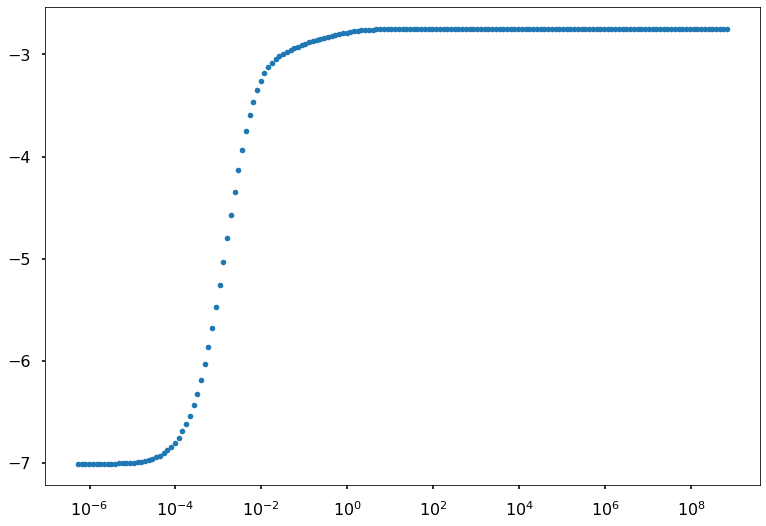

In [54]:
fig,ax = plt.subplots()
ax.plot(pert.freq,-np.real(Fz),'.')
ax.set_xscale('log')

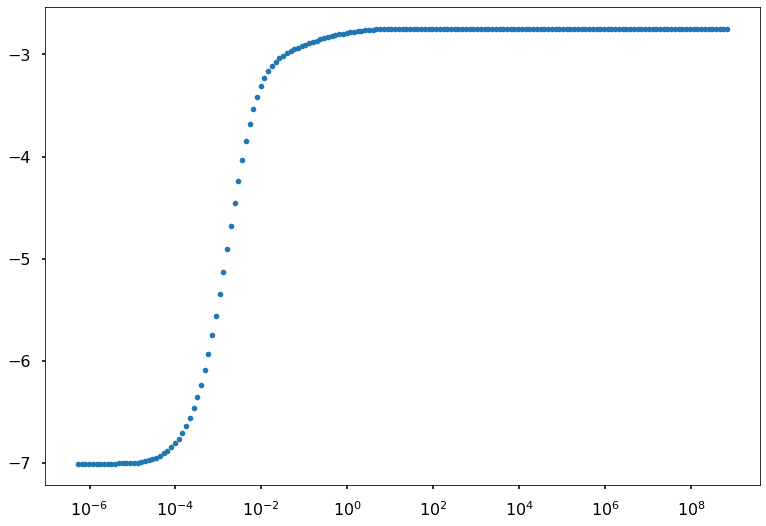

In [52]:
fig,ax = plt.subplots()
ax.plot(pert.freq,-force,'.')
ax.set_xscale('log')

   time        [s] :  1E-06 - 1E+06 : 301  [min-max; #]
   Fourier         :  FFTLog
     > pts_per_dec :  10
     > add_dec     :  [-6.  6.]
     > q           :  -0.6

freq_1 min - max: 5.34E-07 - 6.93E+08
freq_2 min - max: 1.79E-13 - 1.42E+11


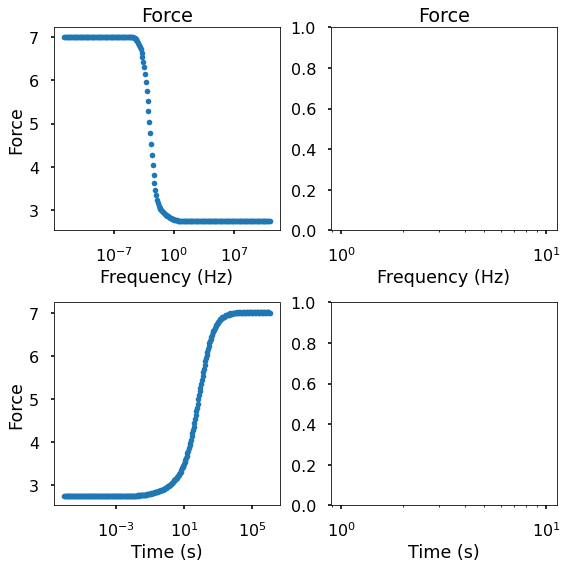

In [55]:
from scipy.interpolate import InterpolatedUnivariateSpline as iuSpline

def test(fem,x,y,i=0):
    time = np.logspace(-6,6,301)
    signal = 1
    ft = 'fftlog'
    ftarg = {'q':-0.6,'add_dec':[-6,6]}
    #ft = 'fft'
    #ftarg={'dfreq': .0005, 'nfreq': 2**8, 'pts_per_dec': 10,'add_dec':[-2,5]}
    time,freq,ft,ftarg = fem.argft(time,signal,ft,ftarg)
    print('freq_1 min - max: {0:.2E} - {1:.2E}'.format(min(fem.freq),max(fem.freq)))
    print('freq_2 min - max: {0:.2E} - {1:.2E}'.format(min(freq),max(freq)))
    fsol_in = fem.fsol[i][:,fem.mesh.is_on_stern,:]
    fsol_out = np.zeros((len(freq),len(fem.mesh.nodes),fsol_in.shape[2]),
                        dtype=complex)

    fsol_in = np.zeros_like(fsol_in)
    fsol_out = np.zeros_like(fsol_out)
    nodes = fem.mesh.nodes[fem.mesh.is_on_stern,:]
    n_ind = np.argmin((nodes[:,0]-x)**2+(nodes[:,1]-y)**2)
    fsol_in[:,n_ind,-2] = force
    
    fsol_1 = np.zeros((len(freq),fsol_in.shape[1],fsol_in.shape[2]),dtype=float)
    fsol_2 = np.zeros((len(freq),fsol_in.shape[1],fsol_in.shape[2]),dtype=float)
    for j in range(fsol_in.shape[1]):
        for k in range(fsol_in.shape[2]):
            func_1 = iuSpline(fem.freq,np.real(fsol_in[:,j,k]))
            fsol_1[:,j,k] = func_1(freq)
            func_2 = iuSpline(fem.freq,np.imag(fsol_in[:,j,k]))
            fsol_2[:,j,k] = func_2(freq)
            mask = freq<min(fem.freq)
            fsol_1[mask,j,k] = np.real(fsol_in[0,j,k])
            fsol_2[mask,j,k] = np.imag(fsol_in[0,j,k])
            mask = freq>max(fem.freq)
            fsol_1[mask,j,k] = np.real(fsol_in[-1,j,k])
            fsol_2[mask,j,k] = np.imag(fsol_in[-1,j,k])
            #fsol_1[:,j,k] = np.real(fsol_in[:,j,k])
            #fsol_2[:,j,k] = np.imag(fsol_in[:,j,k])
    fsol_out[:,fem.mesh.is_on_stern,:] = fsol_1+1j*fsol_2
    fsol = fsol_out[:,fem.mesh.is_on_stern,:]
    tsol = fem.transform([fsol_out],freq,time,signal,ft,ftarg)[0]

    if True:
        nodes = fem.mesh.nodes[fem.mesh.is_on_stern,:]
        n_ind = np.argmin((nodes[:,0]-x)**2+(nodes[:,1]-y)**2)

        fig,ax = plt.subplots(2,2,figsize=(8,8))
        axes = ax.flatten()

        axes[0].plot(freq,np.real(fsol[:,n_ind,-2]),'.')
#         axes[1].plot(freq,np.real(fsol[:,n_ind,-1]),'.')
        axes[2].plot(time,np.real(tsol[:,n_ind,-2]),'.')
#         axes[3].plot(time,np.real(tsol[:,n_ind,-1]),'.')

        axes[0].set_xscale('log')
        axes[1].set_xscale('log')
        axes[2].set_xscale('log')
        axes[3].set_xscale('log')

        axes[0].set_xlabel('Frequency (Hz)')
        axes[1].set_xlabel('Frequency (Hz)')
        axes[2].set_xlabel('Time (s)')
        axes[3].set_xlabel('Time (s)')
        
        axes[0].set_ylabel('Force')
#         axes[1].set_ylabel('$\delta \Sigma_s \;(C/m^2)$')
        axes[2].set_ylabel('Force')
#         axes[3].set_ylabel('$\delta \Sigma_s \;(C/m^2)$')
        
        #axes[0].set_ylabel('(V)')
        #axes[1].set_ylabel('(C/m^2)')
        #axes[2].set_ylabel('(V)')
        #axes[3].set_ylabel('(C/m^2)')

        #axes[0].set_title('(X,Y) = ({0:.2e},{1:.2e})'.format(x,y))
        #axes[1].set_title('(X,Y) = ({0:.2e},{1:.2e})'.format(x,y))

        axes[0].set_title('Force')
        axes[1].set_title('Force')
#         axes[2].set_title('$\delta U_s$')
#         axes[3].set_title('$\delta \Sigma_s$')

        plt.tight_layout()
        plt.show()
    return

if __name__=='__main__':
    test(pert,x=0,y=0)

Computing fields and gradients in elements
Time elapsed  0.14909648895263672 sec



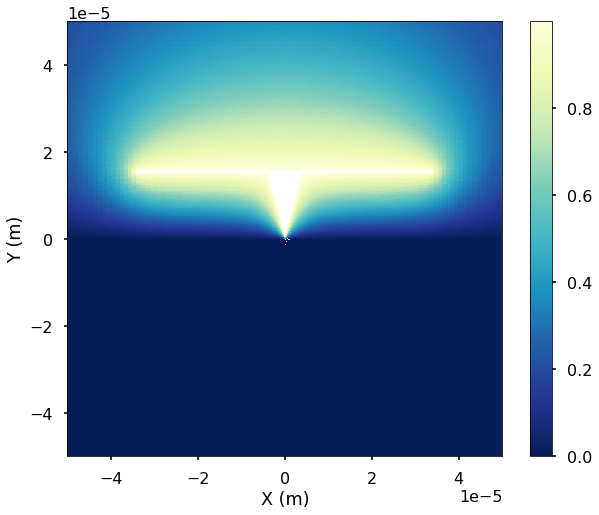

Computing fields and gradients in elements
Time elapsed  0.16556763648986816 sec



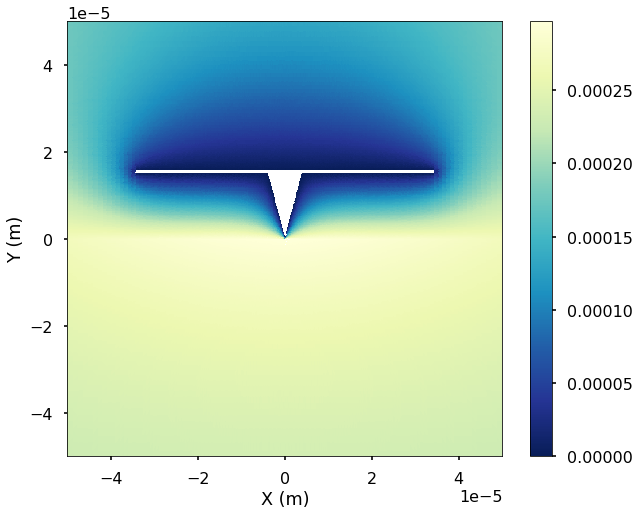

In [100]:
#display results
xlim = [-50e-6,50e-6]
ylim = [-50e-6,50e-6]
pert1.mesh.tripcolor(np.real(pert1.__dict__['ratio:1.00'][0,:,-2]),cmap='YlGnBu_r',xlim=xlim,ylim=ylim)
pert1.mesh.tripcolor(np.imag(pert1.__dict__['ratio:1.00'][0,:,-2]),cmap='YlGnBu_r',xlim=xlim,ylim=ylim)

## load Simulation I

In [3]:
from lib.assembly import PertFEM
tmp = PertFEM.load('capsol/pert_s20.0nm')

In [85]:
tmp.__dict__.keys()

dict_keys(['freq', 'ratio', 'ratio:1.00', 'mesh'])

In [6]:
tmp.fsol = [tmp.__dict__['ratio:1.00']]

Computing fields and gradients in elements
Time elapsed  0.16507172584533691 sec



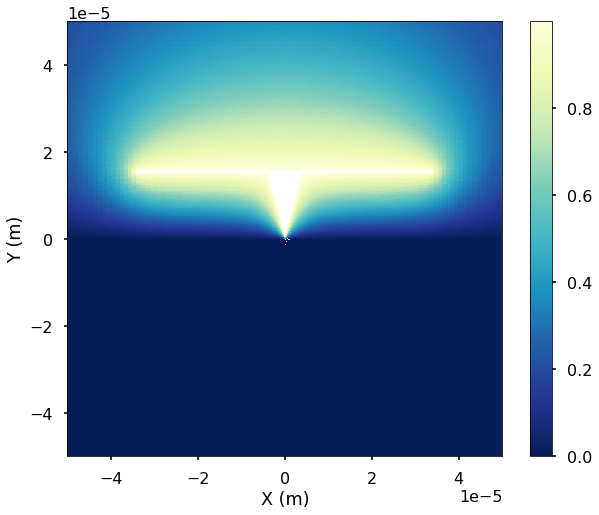

Computing fields and gradients in elements
Time elapsed  0.1575181484222412 sec



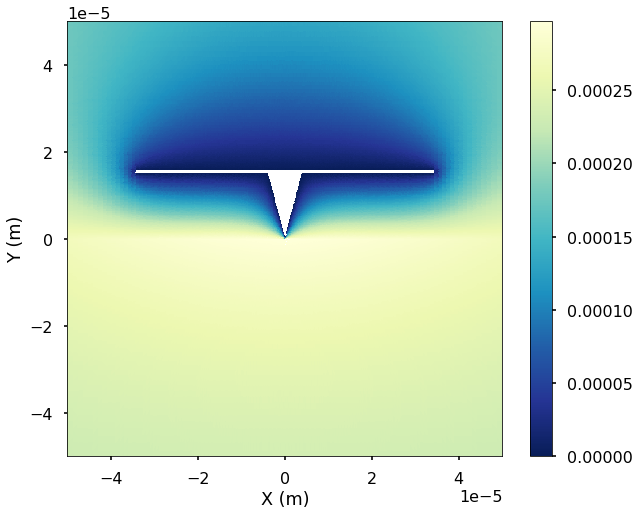

In [87]:
#display results
xlim = [-50e-6,50e-6]
ylim = [-50e-6,50e-6]
tmp.mesh.tripcolor(np.real(tmp.fsol[0][0,:,-2]),cmap='YlGnBu_r',xlim=xlim,ylim=ylim)
tmp.mesh.tripcolor(np.imag(tmp.fsol[0][0,:,-2]),cmap='YlGnBu_r',xlim=xlim,ylim=ylim)

THE NUMBER OF NODES IS: 436371
THE NUMBER OF ELEMENTS IS: 828978
THE NUMBER OF EDGES IS: 1244990

node_flags [ 0  1  2  3  4 11 12 14]
elem_flags [1 2 3]
edge_flags [ 0  1  2  3  4 11 12 14]



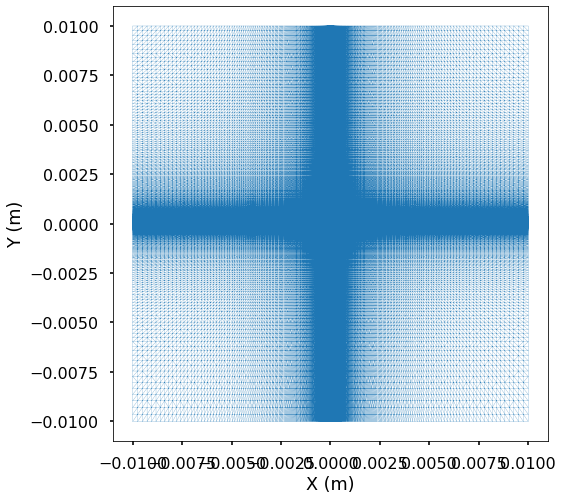

In [90]:
tmp.mesh.visualize(xlim=[],ylim=[])

In [4]:
tmp.mesh.nodes

array([[ 0.00000000e+00, -1.00000200e-02],
       [ 1.00000000e-09, -1.00000200e-02],
       [ 1.97385527e-09, -1.00000200e-02],
       ...,
       [ 9.51257298e-03,  1.00000000e-02],
       [ 9.75324203e-03,  1.00000000e-02],
       [ 1.00000000e-02,  1.00000000e-02]])

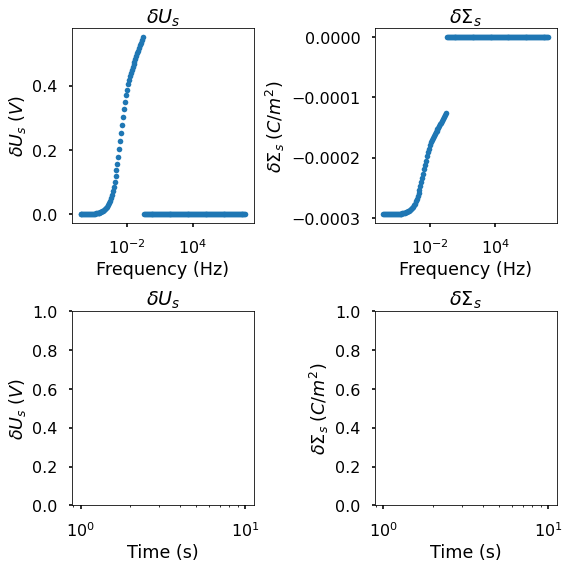

In [7]:
tmp.plot2(x=0,y=0)

In [8]:
tmp.freq.shape

(175,)

In [19]:
import numpy as np
print(np.sum(tmp.fsol[0][66,:,:]))
print(np.sum(tmp.fsol[0][67,:,:]))

(77061.64837987872+1326.9721586905218j)
0j


Computing fields and gradients in elements
Time elapsed  0.5152795314788818 sec



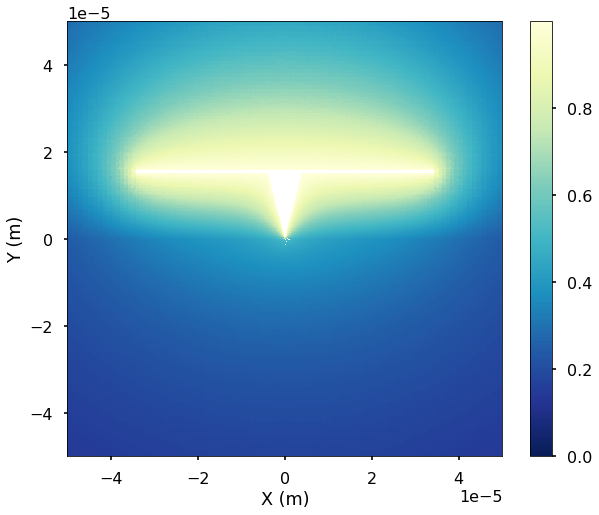

Computing fields and gradients in elements
Time elapsed  0.19894790649414062 sec



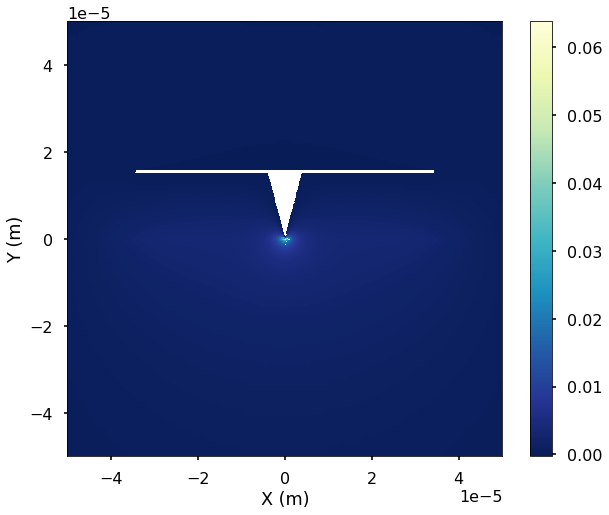

In [20]:
#display results
xlim = [-50e-6,50e-6]
ylim = [-50e-6,50e-6]
tmp.mesh.tripcolor(np.real(tmp.fsol[0][66,:,-2]),cmap='YlGnBu_r',xlim=xlim,ylim=ylim)
tmp.mesh.tripcolor(np.imag(tmp.fsol[0][66,:,-2]),cmap='YlGnBu_r',xlim=xlim,ylim=ylim)

Computing fields and gradients in elements
Time elapsed  0.1841564178466797 sec



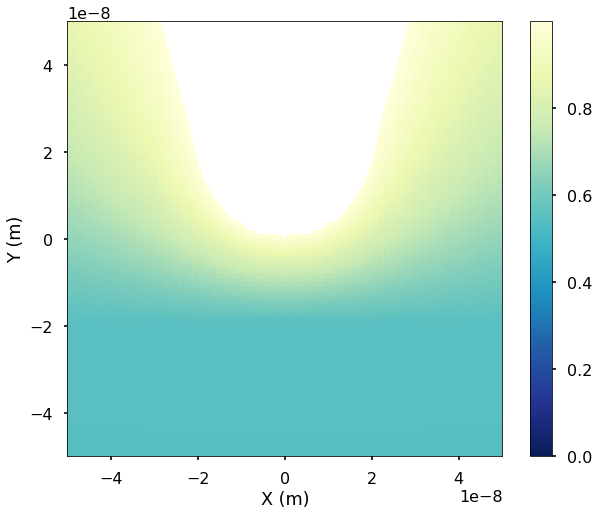

Computing fields and gradients in elements
Time elapsed  0.15606951713562012 sec



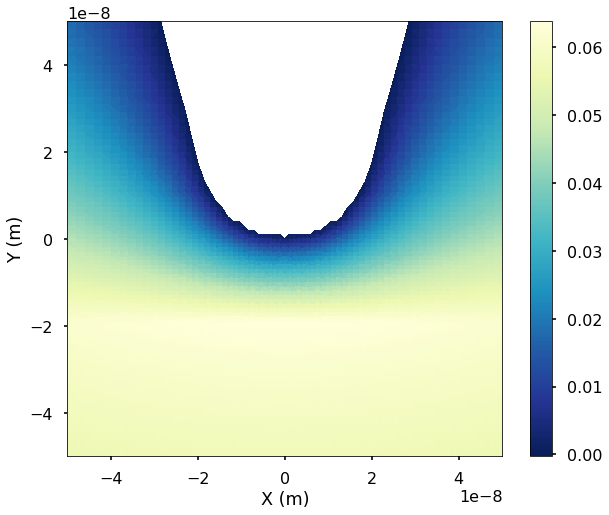

In [21]:
#display results
xlim = [-50e-9,50e-9]
ylim = [-50e-9,50e-9]
tmp.mesh.tripcolor(np.real(tmp.fsol[0][66,:,-2]),cmap='YlGnBu_r',xlim=xlim,ylim=ylim)
tmp.mesh.tripcolor(np.imag(tmp.fsol[0][66,:,-2]),cmap='YlGnBu_r',xlim=xlim,ylim=ylim)

## Load Simulation II

In [8]:
from lib.assembly import FEM
tmp = FEM.load('capsol/grad_s20.0nm')

Computing fields and gradients in elements
Time elapsed  0.1847667694091797 sec



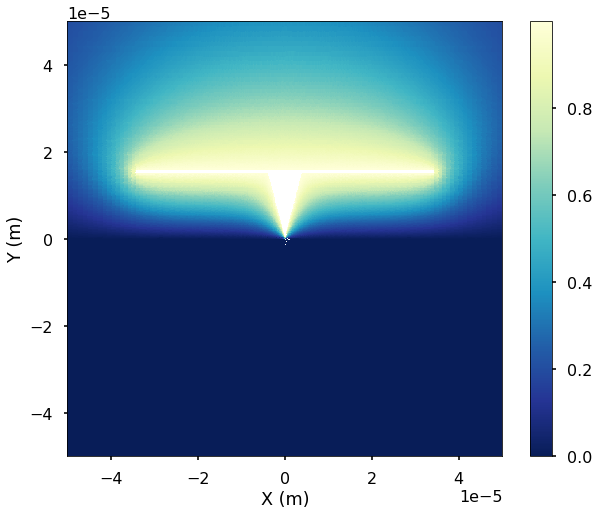

Computing fields and gradients in elements
Time elapsed  0.16113042831420898 sec



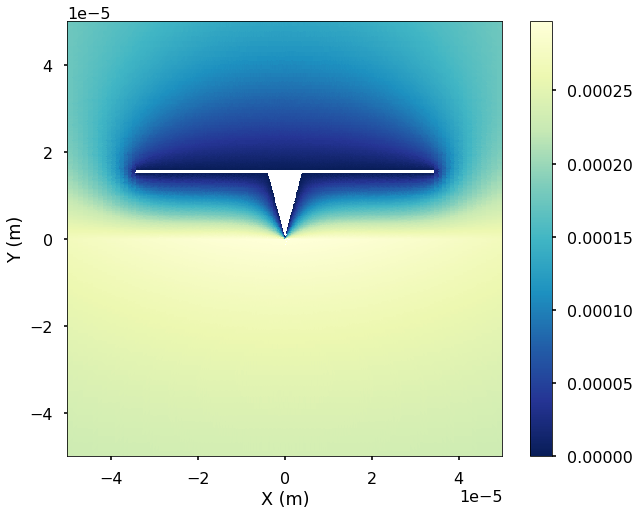

In [96]:
#display results
xlim = [-50e-6,50e-6]
ylim = [-50e-6,50e-6]
tmp.mesh.tripcolor(np.real(tmp.fsol[0,:]),cmap='YlGnBu_r',xlim=xlim,ylim=ylim)
tmp.mesh.tripcolor(np.imag(tmp.fsol[0,:]),cmap='YlGnBu_r',xlim=xlim,ylim=ylim)

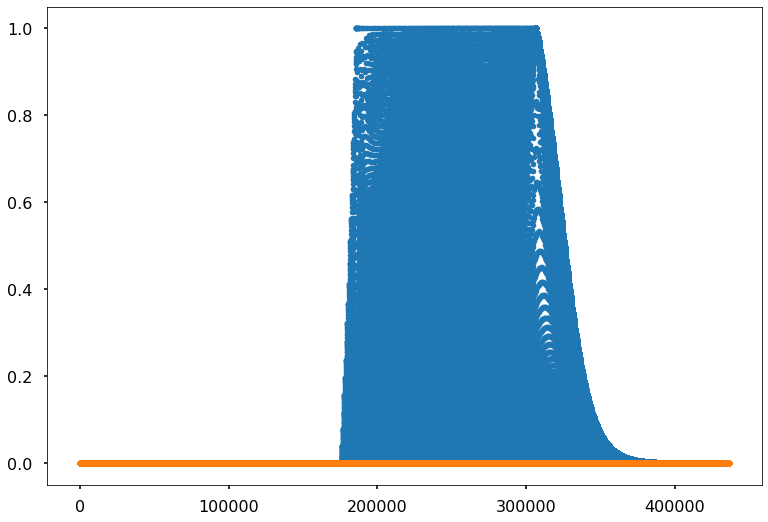

In [93]:
fig,ax = plt.subplots()
ax.plot(tmp.fsol[0,:],'.')
# ax.plot(np.real(fsol[0,:,-2]),'.')
ax.plot(tmp.fsol[0,:]-np.real(fsol[0,:,-2]),'.')

## Load Simulation III

In [57]:
from lib.assembly import FEM
fem = FEM.load('capsol/grad2_s18.0nm')
fem.freq = pert.freq

In [61]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

import numpy as np
import os

from lib.mesh import Mesh,Probe,generate_grid
from lib.materials import Consts,PDE
from lib.assembly import FEM
from lib.utils import print_tstamp

inparg = {'n':500,'m':500,'l_js':350, #number of grids: x,z+,z- below sample top
          'h0':1,'rho_max':10e6,'z_max':10e6, #resolution: h0, box_size (rho_max,z_max)
          'd_min':2,'d_max':20,'id_step':1, #tip-sample separation: min,max,istep (stepsize=istep*h0)
          'eps_r':5.9,'Hsam':10e6} #sample: eps_r, thickness_sample

# height_gap = np.arange(2,21,1)
height_gap = [18.0]
force = np.zeros(len(fem.freq))
for i in range(len(height_gap)):
#     for j in range(len(pert.freq)):
    #update grid discretization
    inparg['d_min'] = height_gap[i]
    x,y = generate_grid(**inparg)

    #mesh_prefix = 'test/stat_s{:02.1f}nm'.format(height_gap[i])
    #mesh_prefix = 'capsol/test_4/test4_s{:02.1f}nm'.format(height_gap[i])
    #print(mesh_prefix)
    #stat = FEM.load(mesh_prefix)
    fem.mesh.grid_x = x*fem.mesh.unscale_factor
    fem.mesh.grid_y = y*fem.mesh.unscale_factor
    f_out,Fz_2 = fem.mesh.force2d((fem.fsol[:,:]))
    #os.rename('force.out',mesh_prefix+'.fz')
    #force[j] = np.sum(f_out[:,2])
    #print('freq',pert.freq[j],'force',force[j])
    print('Done')

Done


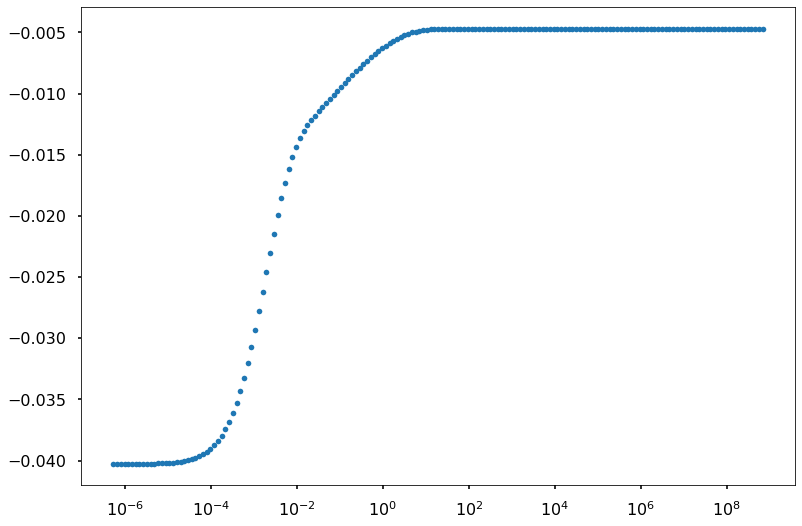

In [68]:
fig,ax = plt.subplots()
# ax.plot(fem.freq,-np.real(Fz_2),'.')
# ax.plot(pert.freq,-np.real(Fz),'.')
ax.plot(pert.freq,np.real(Fz-Fz_2)/2,'.')
ax.set_xscale('log')

   time        [s] :  1E-06 - 1E+06 : 301  [min-max; #]
   Fourier         :  FFTLog
     > pts_per_dec :  10
     > add_dec     :  [-6.  6.]
     > q           :  -0.6

freq_1 min - max: 5.34E-07 - 6.93E+08
freq_2 min - max: 1.79E-13 - 1.42E+11


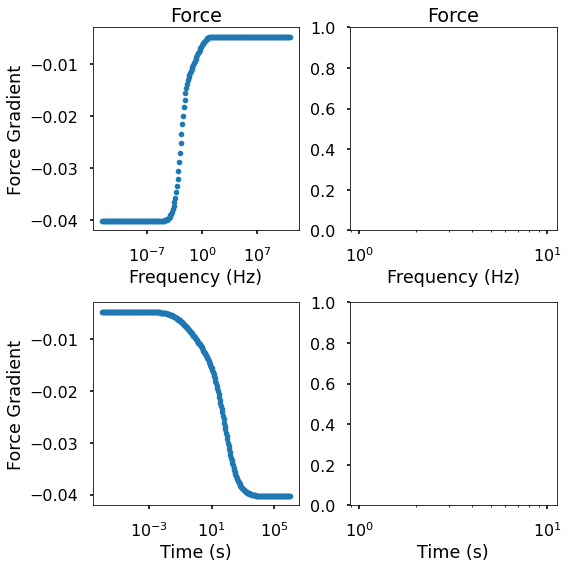

In [71]:
from scipy.interpolate import InterpolatedUnivariateSpline as iuSpline

def test(fem,x,y,i=0):
    time = np.logspace(-6,6,301)
    signal = 1
    ft = 'fftlog'
    ftarg = {'q':-0.6,'add_dec':[-6,6]}
    #ft = 'fft'
    #ftarg={'dfreq': .0005, 'nfreq': 2**8, 'pts_per_dec': 10,'add_dec':[-2,5]}
    time,freq,ft,ftarg = fem.argft(time,signal,ft,ftarg)
    print('freq_1 min - max: {0:.2E} - {1:.2E}'.format(min(fem.freq),max(fem.freq)))
    print('freq_2 min - max: {0:.2E} - {1:.2E}'.format(min(freq),max(freq)))
    fsol_in = fem.fsol[i][:,fem.mesh.is_on_stern,:]
    fsol_out = np.zeros((len(freq),len(fem.mesh.nodes),fsol_in.shape[2]),
                        dtype=complex)

    fsol_in = np.zeros_like(fsol_in)
    fsol_out = np.zeros_like(fsol_out)
    nodes = fem.mesh.nodes[fem.mesh.is_on_stern,:]
    n_ind = np.argmin((nodes[:,0]-x)**2+(nodes[:,1]-y)**2)
    fsol_in[:,n_ind,-2] = (Fz-Fz_2)/2
    
    fsol_1 = np.zeros((len(freq),fsol_in.shape[1],fsol_in.shape[2]),dtype=float)
    fsol_2 = np.zeros((len(freq),fsol_in.shape[1],fsol_in.shape[2]),dtype=float)
    for j in range(fsol_in.shape[1]):
        for k in range(fsol_in.shape[2]):
            func_1 = iuSpline(fem.freq,np.real(fsol_in[:,j,k]))
            fsol_1[:,j,k] = func_1(freq)
            func_2 = iuSpline(fem.freq,np.imag(fsol_in[:,j,k]))
            fsol_2[:,j,k] = func_2(freq)
            mask = freq<min(fem.freq)
            fsol_1[mask,j,k] = np.real(fsol_in[0,j,k])
            fsol_2[mask,j,k] = np.imag(fsol_in[0,j,k])
            mask = freq>max(fem.freq)
            fsol_1[mask,j,k] = np.real(fsol_in[-1,j,k])
            fsol_2[mask,j,k] = np.imag(fsol_in[-1,j,k])
            #fsol_1[:,j,k] = np.real(fsol_in[:,j,k])
            #fsol_2[:,j,k] = np.imag(fsol_in[:,j,k])
    fsol_out[:,fem.mesh.is_on_stern,:] = fsol_1+1j*fsol_2
    fsol = fsol_out[:,fem.mesh.is_on_stern,:]
    tsol = fem.transform([fsol_out],freq,time,signal,ft,ftarg)[0]

    if True:
        nodes = fem.mesh.nodes[fem.mesh.is_on_stern,:]
        n_ind = np.argmin((nodes[:,0]-x)**2+(nodes[:,1]-y)**2)

        fig,ax = plt.subplots(2,2,figsize=(8,8))
        axes = ax.flatten()

        axes[0].plot(freq,np.real(fsol[:,n_ind,-2]),'.')
#         axes[1].plot(freq,np.real(fsol[:,n_ind,-1]),'.')
        axes[2].plot(time,np.real(tsol[:,n_ind,-2]),'.')
#         axes[3].plot(time,np.real(tsol[:,n_ind,-1]),'.')

        axes[0].set_xscale('log')
        axes[1].set_xscale('log')
        axes[2].set_xscale('log')
        axes[3].set_xscale('log')

        axes[0].set_xlabel('Frequency (Hz)')
        axes[1].set_xlabel('Frequency (Hz)')
        axes[2].set_xlabel('Time (s)')
        axes[3].set_xlabel('Time (s)')
        
        axes[0].set_ylabel('Force Gradient')
#         axes[1].set_ylabel('$\delta \Sigma_s \;(C/m^2)$')
        axes[2].set_ylabel('Force Gradient')
#         axes[3].set_ylabel('$\delta \Sigma_s \;(C/m^2)$')
        
        #axes[0].set_ylabel('(V)')
        #axes[1].set_ylabel('(C/m^2)')
        #axes[2].set_ylabel('(V)')
        #axes[3].set_ylabel('(C/m^2)')

        #axes[0].set_title('(X,Y) = ({0:.2e},{1:.2e})'.format(x,y))
        #axes[1].set_title('(X,Y) = ({0:.2e},{1:.2e})'.format(x,y))

        axes[0].set_title('Force')
        axes[1].set_title('Force')
#         axes[2].set_title('$\delta U_s$')
#         axes[3].set_title('$\delta \Sigma_s$')

        plt.tight_layout()
        plt.show()
    return

if __name__=='__main__':
    test(pert,x=0,y=0)

Computing fields and gradients in elements
Time elapsed  0.12720513343811035 sec



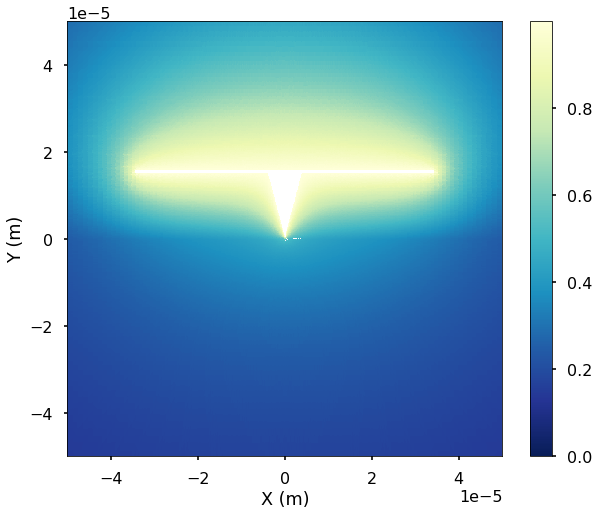

Computing fields and gradients in elements
Time elapsed  0.12527108192443848 sec



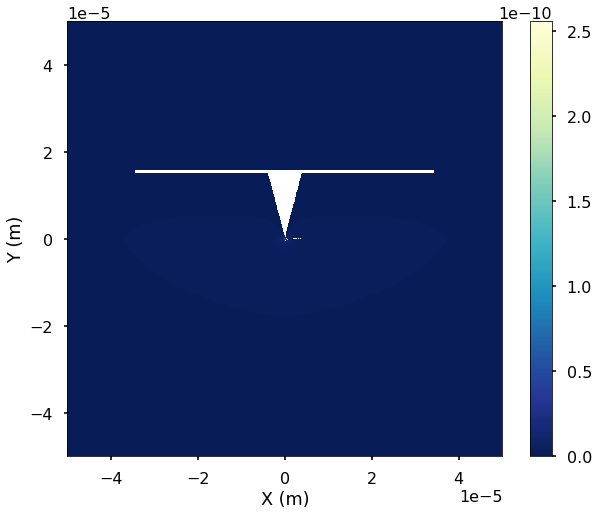

In [29]:
import numpy as np
#display results
xlim = [-50e-6,50e-6]
ylim = [-50e-6,50e-6]
tmp2.mesh.tripcolor(np.real(tmp2.fsol[-1,:]),cmap='YlGnBu_r',xlim=xlim,ylim=ylim)
tmp2.mesh.tripcolor(np.imag(tmp2.fsol[-1,:]),cmap='YlGnBu_r',xlim=xlim,ylim=ylim)

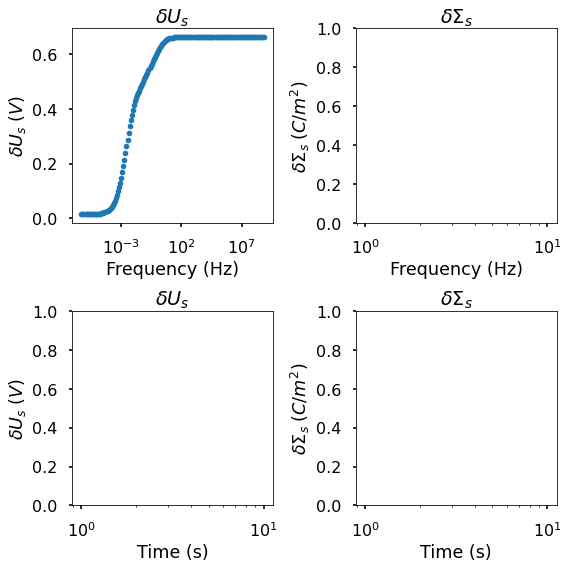

In [37]:
tmp2.freq = pert1.freq
tmp2.plot2(x=0,y=0)